In [1]:
import os
from functools import partial
import numba
import math
import numpy as np
from scipy.special import erf
from scipy.stats import norm

import torch
import torch.nn.functional as F
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning.core import LightningModule
from torch.cuda.amp.autocast_mode import autocast
from torch.optim.lr_scheduler import MultiStepLR
from torch import nn
from torch.cuda.amp.autocast_mode import autocast
from torch.cuda.amp import autocast
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset

import torchvision.models as models
import torch.utils.model_zoo as model_zoo

import mmcv
from mmcv.cnn import build_conv_layer
from mmcv.runner import load_checkpoint

from mmdet.models import build_backbone
from mmdet.models.backbones.resnet import BasicBlock
from mmdet.core import reduce_mean

from mmdet3d.core import draw_heatmap_gaussian, gaussian_radius
from mmdet3d.models import build_neck
from mmdet3d.models.dense_heads.centerpoint_head import CenterHead, circle_nms
from mmdet3d.models.utils import clip_sigmoid
from mmdet3d.models import build_neck

from bevdepth.evaluators.det_evaluators import DetNuscEvaluator
from nuscenes.utils.data_classes import Box
from bevdepth.callbacks.ema import EMACallback
from bevdepth.utils.torch_dist import all_gather_object, get_rank, synchronize

try:
    from bevdepth.ops.voxel_pooling import voxel_pooling
except ImportError:
    print('Import VoxelPooling fail.')
    
from mmdet3d.core.bbox.structures.lidar_box3d import LiDARInstance3DBoxes
from nuscenes.utils.data_classes import Box, LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
from PIL import Image
from pyquaternion import Quaternion
import pyquaternion

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from nuscenes.utils.data_classes import Box, LidarPointCloud
from collections import OrderedDict


from bevdepth.datasets.insta360_det_dataset import map_name_from_general_to_detection
from bevdepth.datasets.insta360_det_dataset import NuscDetDataset, collate_fn



# Visualization

In [2]:
infos_path = '../data/nuscenes/nuscenes_infos_val.pkl'
infos = mmcv.load(infos_path)

In [3]:
def get_ego_box(box_dict, ego2global_rotation, ego2global_translation):
    box = Box(
        box_dict['translation'],
        box_dict['size'],
        Quaternion(box_dict['rotation']),
    )
    trans = -np.array(ego2global_translation)
    rot = Quaternion(ego2global_rotation).inverse
    box.translate(trans)
    box.rotate(rot)
    box_xyz = np.array(box.center)
    box_dxdydz = np.array(box.wlh)[[1, 0, 2]]
    box_yaw = np.array([box.orientation.yaw_pitch_roll[0]])
    box_velo = np.array(box.velocity[:2])
    return np.concatenate([box_xyz, box_dxdydz, box_yaw, box_velo])


def rotate_points_along_z(points, angle):
    """
    Args:
        points: (B, N, 3 + C)
        angle: (B), angle along z-axis, angle increases x ==> y
    Returns:
    """
    cosa = np.cos(angle)
    sina = np.sin(angle)
    zeros = np.zeros(points.shape[0])
    ones = np.ones(points.shape[0])
    rot_matrix = np.stack(
        (cosa, sina, zeros, -sina, cosa, zeros, zeros, zeros, ones),
        axis=1).reshape(-1, 3, 3)
    points_rot = np.matmul(points[:, :, 0:3], rot_matrix)
    points_rot = np.concatenate((points_rot, points[:, :, 3:]), axis=-1)
    return points_rot


def get_corners(boxes3d):
    """
        7 -------- 4
       /|         /|
      6 -------- 5 .
      | |        | |
      . 3 -------- 0
      |/         |/
      2 -------- 1
    Args:
        boxes3d:  (N, 7) [x, y, z, dx, dy, dz, heading],
            (x, y, z) is the box center
    Returns:
    """
    template = (np.array((
        [1, 1, -1],
        [1, -1, -1],
        [-1, -1, -1],
        [-1, 1, -1],
        [1, 1, 1],
        [1, -1, 1],
        [-1, -1, 1],
        [-1, 1, 1],
    )) / 2)

    corners3d = np.tile(boxes3d[:, None, 3:6], [1, 8, 1]) * template[None, :, :]
    corners3d = rotate_points_along_z(corners3d.reshape(-1, 8, 3),boxes3d[:, 6]).reshape(-1, 8, 3)
    corners3d += boxes3d[:, None, 0:3]

    return corners3d

def get_bev_lines(corners):
    return [[[corners[i, 0], corners[(i + 1) % 4, 0]],
             [corners[i, 1], corners[(i + 1) % 4, 1]]] for i in range(4)]

def get_3d_lines(corners):
    ret = []
    for st, ed in [[0, 1], [1, 2], [2, 3], [3, 0], [4, 5], [5, 6], [6, 7],
                   [7, 4], [0, 4], [1, 5], [2, 6], [3, 7]]:
        if corners[st, -1] > 0 and corners[ed, -1] > 0:
            ret.append([[corners[st, 0], corners[ed, 0]],
                        [corners[st, 1], corners[ed, 1]]])
    return ret

def get_cam_corners(corners, translation, rotation, cam_intrinsics):
    cam_corners = corners.copy()
    cam_corners -= np.array(translation)
    cam_corners = cam_corners @ Quaternion(rotation).inverse.rotation_matrix.T
    cam_corners = cam_corners @ np.array(cam_intrinsics).T
    valid = cam_corners[:, -1] > 0
    cam_corners /= cam_corners[:, 2:3]
    cam_corners[~valid] = 0
    return cam_corners

# Base Backbone (BEVDepth) 

In [4]:
"""from layers/backbones/base_lss_fpn"""

class _ASPPModule(nn.Module):

    def __init__(self, inplanes, planes, kernel_size, padding, dilation,
                 BatchNorm):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes,
                                     planes,
                                     kernel_size=kernel_size,
                                     stride=1,
                                     padding=padding,
                                     dilation=dilation,
                                     bias=False)
        self.bn = BatchNorm(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
class ASPP(nn.Module):

    def __init__(self, inplanes, mid_channels=256, BatchNorm=nn.BatchNorm2d):
        super(ASPP, self).__init__()

        dilations = [1, 6, 12, 18]

        self.aspp1 = _ASPPModule(inplanes,
                                 mid_channels,
                                 1,
                                 padding=0,
                                 dilation=dilations[0],
                                 BatchNorm=BatchNorm)
        self.aspp2 = _ASPPModule(inplanes,
                                 mid_channels,
                                 3,
                                 padding=dilations[1],
                                 dilation=dilations[1],
                                 BatchNorm=BatchNorm)
        self.aspp3 = _ASPPModule(inplanes,
                                 mid_channels,
                                 3,
                                 padding=dilations[2],
                                 dilation=dilations[2],
                                 BatchNorm=BatchNorm)
        self.aspp4 = _ASPPModule(inplanes,
                                 mid_channels,
                                 3,
                                 padding=dilations[3],
                                 dilation=dilations[3],
                                 BatchNorm=BatchNorm)

        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(inplanes, mid_channels, 1, stride=1, bias=False),
            BatchNorm(mid_channels),
            nn.ReLU(),
        )
        self.conv1 = nn.Conv2d(int(mid_channels * 5),
                               mid_channels,
                               1,
                               bias=False)
        self.bn1 = BatchNorm(mid_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self._init_weight()

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5,
                           size=x4.size()[2:],
                           mode='bilinear',
                           align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Mlp(nn.Module):

    def __init__(self,
                 in_features,
                 hidden_features=None,
                 out_features=None,
                 act_layer=nn.ReLU,
                 drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


class SELayer(nn.Module):

    def __init__(self, channels, act_layer=nn.ReLU, gate_layer=nn.Sigmoid):
        super().__init__()
        self.conv_reduce = nn.Conv2d(channels, channels, 1, bias=True)
        self.act1 = act_layer()
        self.conv_expand = nn.Conv2d(channels, channels, 1, bias=True)
        self.gate = gate_layer()

    def forward(self, x, x_se):
        x_se = self.conv_reduce(x_se)
        x_se = self.act1(x_se)
        x_se = self.conv_expand(x_se)
        return x * self.gate(x_se)

class DepthAggregation(nn.Module):
    """
    pixel cloud feature extraction
    """

    def __init__(self, in_channels, mid_channels, out_channels):
        super(DepthAggregation, self).__init__()

        self.reduce_conv = nn.Sequential(
            nn.Conv2d(in_channels,
                      mid_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
        )

        self.conv = nn.Sequential(
            nn.Conv2d(mid_channels,
                      mid_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels,
                      mid_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
        )

        self.out_conv = nn.Sequential(
            nn.Conv2d(mid_channels,
                      out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=True),
            # nn.BatchNorm3d(out_channels),
            # nn.ReLU(inplace=True),
        )

    @autocast(False)
    def forward(self, x):
        x = self.reduce_conv(x)
        x = self.conv(x) + x
        x = self.out_conv(x)
        return x

class BaseLSSFPN(nn.Module):

    def __init__(self,
                 x_bound,
                 y_bound,
                 z_bound,
                 d_bound,
                 final_dim,
                 downsample_factor,
                 output_channels,
                 img_backbone_conf,
                 img_neck_conf,
                 depth_net_conf,
                 device='cuda:0',
                 use_da=True): # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 임의로 바꿈
        """Modified from `https://github.com/nv-tlabs/lift-splat-shoot`.

        Args:
            x_bound (list): Boundaries for x.
            y_bound (list): Boundaries for y.
            z_bound (list): Boundaries for z.
            d_bound (list): Boundaries for d.
            final_dim (list): Dimension for input images.
            downsample_factor (int): Downsample factor between feature map
                and input image.
            output_channels (int): Number of channels for the output
                feature map.
            img_backbone_conf (dict): Config for image backbone.
            img_neck_conf (dict): Config for image neck.
            depth_net_conf (dict): Config for depth net.
        """

        super(BaseLSSFPN, self).__init__()
        self.downsample_factor = downsample_factor
        self.d_bound = d_bound
        self.final_dim = final_dim
        self.output_channels = output_channels

        self.register_buffer(
            'voxel_size',
            torch.Tensor([row[2] for row in [x_bound, y_bound, z_bound]]))
        self.register_buffer(
            'voxel_coord',
            torch.Tensor([
                row[0] + row[2] / 2.0 for row in [x_bound, y_bound, z_bound]
            ]))
        self.register_buffer(
            'voxel_num',
            torch.LongTensor([(row[1] - row[0]) / row[2]
                              for row in [x_bound, y_bound, z_bound]]))
        self.register_buffer('frustum', self.create_frustum())
        self.depth_channels, _, _, _ = self.frustum.shape

        self.img_backbone = build_backbone(img_backbone_conf)
        self.img_neck = build_neck(img_neck_conf)
        self.depth_net = self._configure_depth_net(depth_net_conf)

        self.img_neck.init_weights()
        self.img_backbone.init_weights()
        self.use_da = use_da
        if self.use_da:
            self.depth_aggregation_net = self._configure_depth_aggregation_net()
            
        self.device = device

    def _configure_depth_net(self, depth_net_conf):
        return DepthNet(
            depth_net_conf['in_channels'],
            depth_net_conf['mid_channels'],
            self.output_channels,
            self.depth_channels,
        )

    def _configure_depth_aggregation_net(self):
        """build pixel cloud feature extractor"""
        return DepthAggregation(self.output_channels, self.output_channels, self.output_channels)

    def _forward_voxel_net(self, img_feat_with_depth):
        if self.use_da:
            # BEVConv2D [n, c, d, h, w] -> [n, h, c, w, d]
            img_feat_with_depth = img_feat_with_depth.permute(
                0, 3, 1, 4,
                2).contiguous()  # [n, c, d, h, w] -> [n, h, c, w, d]
            n, h, c, w, d = img_feat_with_depth.shape
            img_feat_with_depth = img_feat_with_depth.view(-1, c, w, d)
            img_feat_with_depth = (
                self.depth_aggregation_net(img_feat_with_depth).view(
                    n, h, c, w, d).permute(0, 2, 4, 1, 3).contiguous().float())
        return img_feat_with_depth

    def create_frustum(self):
        """Generate frustum"""
        # make grid in image plane
        ogfH, ogfW = self.final_dim
        fH, fW = ogfH // self.downsample_factor, ogfW // self.downsample_factor
        d_coords = torch.arange(*self.d_bound,
                                dtype=torch.float).view(-1, 1,
                                                        1).expand(-1, fH, fW)
        D, _, _ = d_coords.shape
        x_coords = torch.linspace(0, ogfW - 1, fW, dtype=torch.float).view(
            1, 1, fW).expand(D, fH, fW)
        y_coords = torch.linspace(0, ogfH - 1, fH,
                                  dtype=torch.float).view(1, fH,
                                                          1).expand(D, fH, fW)
        paddings = torch.ones_like(d_coords)

        # D x H x W x 3
        frustum = torch.stack((x_coords, y_coords, d_coords, paddings), -1)
        return frustum

    def get_geometry(self, sensor2ego_mat, intrin_mat, ida_mat, bda_mat):
        """Transfer points from camera coord to ego coord.

        Args:
            rots(Tensor): Rotation matrix from camera to ego.
            trans(Tensor): Translation matrix from camera to ego.
            intrins(Tensor): Intrinsic matrix.
            post_rots_ida(Tensor): Rotation matrix for ida.
            post_trans_ida(Tensor): Translation matrix for ida
            post_rot_bda(Tensor): Rotation matrix for bda.

        Returns:
            Tensors: points ego coord.
        """
        batch_size, num_cams, _, _ = sensor2ego_mat.shape

        # undo post-transformation
        # B x N x D x H x W x 3
        points = self.frustum
        ida_mat = ida_mat.view(batch_size, num_cams, 1, 1, 1, 4, 4)
        points = ida_mat.inverse().matmul(points.unsqueeze(-1))
        # cam_to_ego
        points = torch.cat(
            (points[:, :, :, :, :, :2] * points[:, :, :, :, :, 2:3],
             points[:, :, :, :, :, 2:]), 5)

        combine = sensor2ego_mat.matmul(torch.inverse(intrin_mat))
        points = combine.view(batch_size, num_cams, 1, 1, 1, 4,
                              4).matmul(points)
        if bda_mat is not None:
            bda_mat = bda_mat.unsqueeze(1).repeat(1, num_cams, 1, 1).view(
                batch_size, num_cams, 1, 1, 1, 4, 4)
            points = (bda_mat @ points).squeeze(-1)
        else:
            points = points.squeeze(-1)
        return points[..., :3]

    def get_cam_feats(self, imgs):
        """Get feature maps from images."""
        batch_size, num_sweeps, num_cams, num_channels, imH, imW = imgs.shape

        imgs = imgs.flatten().view(batch_size * num_sweeps * num_cams,
                                   num_channels, imH, imW)
        img_feats = self.img_neck(self.img_backbone(imgs))[0]
        img_feats = img_feats.reshape(batch_size, num_sweeps, num_cams,
                                      img_feats.shape[1], img_feats.shape[2],
                                      img_feats.shape[3])
        return img_feats

    def _forward_depth_net(self, feat, mats_dict):
        return self.depth_net(feat, mats_dict)

    def _forward_single_sweep(self,
                              sweep_index,
                              sweep_imgs,
                              mats_dict,
                              is_return_depth=False):
        """Forward function for single sweep.

        Args:
            sweep_index (int): Index of sweeps.
            sweep_imgs (Tensor): Input images.
            mats_dict (dict):
                sensor2ego_mats(Tensor): Transformation matrix from
                    camera to ego with shape of (B, num_sweeps,
                    num_cameras, 4, 4).
                intrin_mats(Tensor): Intrinsic matrix with shape
                    of (B, num_sweeps, num_cameras, 4, 4).
                ida_mats(Tensor): Transformation matrix for ida with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                sensor2sensor_mats(Tensor): Transformation matrix
                    from key frame camera to sweep frame camera with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                bda_mat(Tensor): Rotation matrix for bda with shape
                    of (B, 4, 4).
            is_return_depth (bool, optional): Whether to return depth.
                Default: False.

        Returns:
            Tensor: BEV feature map.
        """
        batch_size, num_sweeps, num_cams, num_channels, img_height, \
            img_width = sweep_imgs.shape
        img_feats = self.get_cam_feats(sweep_imgs)
        source_features = img_feats[:, 0, ...]
        depth_feature = self._forward_depth_net(
            source_features.reshape(batch_size * num_cams,
                                    source_features.shape[2],
                                    source_features.shape[3],
                                    source_features.shape[4]),
            mats_dict,
        )
        depth = depth_feature[:, :self.depth_channels].softmax(1)
        img_feat_with_depth = depth.unsqueeze(
            1) * depth_feature[:, self.depth_channels:(
                self.depth_channels + self.output_channels)].unsqueeze(2)

        img_feat_with_depth = self._forward_voxel_net(img_feat_with_depth)

        img_feat_with_depth = img_feat_with_depth.reshape(
            batch_size,
            num_cams,
            img_feat_with_depth.shape[1],
            img_feat_with_depth.shape[2],
            img_feat_with_depth.shape[3],
            img_feat_with_depth.shape[4],
        )
        geom_xyz = self.get_geometry(
            mats_dict['sensor2ego_mats'][:, sweep_index, ...],
            mats_dict['intrin_mats'][:, sweep_index, ...],
            mats_dict['ida_mats'][:, sweep_index, ...],
            mats_dict.get('bda_mat', None),
        )
        img_feat_with_depth = img_feat_with_depth.permute(0, 1, 3, 4, 5, 2)
        geom_xyz = ((geom_xyz - (self.voxel_coord - self.voxel_size / 2.0)) /
                    self.voxel_size).int()
        
        # feature_map = voxel_pooling(geom_xyz, img_feat_with_depth.contiguous(), self.voxel_num.cuda())
        feature_map = voxel_pooling(geom_xyz, img_feat_with_depth.contiguous(), self.voxel_num.to(self.device))
        
        if is_return_depth:
            return feature_map.contiguous(), depth
        return feature_map.contiguous()

    def forward(self,
                sweep_imgs,
                mats_dict,
                timestamps=None,
                is_return_depth=False):
        """Forward function.

        Args:
            sweep_imgs(Tensor): Input images with shape of (B, num_sweeps,
                num_cameras, 3, H, W).
            mats_dict(dict):
                sensor2ego_mats(Tensor): Transformation matrix from
                    camera to ego with shape of (B, num_sweeps,
                    num_cameras, 4, 4).
                intrin_mats(Tensor): Intrinsic matrix with shape
                    of (B, num_sweeps, num_cameras, 4, 4).
                ida_mats(Tensor): Transformation matrix for ida with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                sensor2sensor_mats(Tensor): Transformation matrix
                    from key frame camera to sweep frame camera with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                bda_mat(Tensor): Rotation matrix for bda with shape
                    of (B, 4, 4).
            timestamps(Tensor): Timestamp for all images with the shape of(B,
                num_sweeps, num_cameras).

        Return:
            Tensor: bev feature map.
        """
        batch_size, num_sweeps, num_cams, num_channels, img_height, img_width = sweep_imgs.shape

        key_frame_res = self._forward_single_sweep(
            0,
            sweep_imgs[:, 0:1, ...],
            mats_dict,
            is_return_depth=is_return_depth)
        if num_sweeps == 1:
            return key_frame_res

        key_frame_feature = key_frame_res[
            0] if is_return_depth else key_frame_res

        ret_feature_list = [key_frame_feature]
        for sweep_index in range(1, num_sweeps):
            with torch.no_grad():
                feature_map = self._forward_single_sweep(
                    sweep_index,
                    sweep_imgs[:, sweep_index:sweep_index + 1, ...],
                    mats_dict,
                    is_return_depth=False)
                ret_feature_list.append(feature_map)

        if is_return_depth:
            return torch.cat(ret_feature_list, 1), key_frame_res[1]
        else:
            return torch.cat(ret_feature_list, 1)


# BEVStereo Backbone (LSS)

In [64]:
"""from layers/backbones/bevstereo_lss_fpn.py"""

class ConvBnReLU3D(nn.Module):
    """Implements of 3d convolution + batch normalization + ReLU."""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        pad: int = 1,
        dilation: int = 1,
    ) -> None:
        """initialization method for convolution3D +
            batch normalization + relu module
        Args:
            in_channels: input channel number of convolution layer
            out_channels: output channel number of convolution layer
            kernel_size: kernel size of convolution layer
            stride: stride of convolution layer
            pad: pad of convolution layer
            dilation: dilation of convolution layer
        """
        super(ConvBnReLU3D, self).__init__()
        self.conv = nn.Conv3d(in_channels,
                              out_channels,
                              kernel_size,
                              stride=stride,
                              padding=pad,
                              dilation=dilation,
                              bias=False)
        self.bn = nn.BatchNorm3d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """forward method"""
        return F.relu(self.bn(self.conv(x)), inplace=True)


class DepthNet(nn.Module):

    def __init__(self,
                 in_channels,
                 mid_channels,
                 context_channels,
                 depth_channels,
                 d_bound,
                 num_ranges=4):
        super(DepthNet, self).__init__()
        self.reduce_conv = nn.Sequential(
            nn.Conv2d(in_channels,
                      mid_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
        )
        self.context_conv = nn.Conv2d(mid_channels,
                                      context_channels,
                                      kernel_size=1,
                                      stride=1,
                                      padding=0)
        self.bn = nn.BatchNorm1d(27)
        self.depth_mlp = Mlp(27, mid_channels, mid_channels)
        self.depth_se = SELayer(mid_channels)  # NOTE: add camera-aware
        self.context_mlp = Mlp(27, mid_channels, mid_channels)
        self.context_se = SELayer(mid_channels)  # NOTE: add camera-aware
        self.depth_feat_conv = nn.Sequential(
            BasicBlock(mid_channels, mid_channels),
            BasicBlock(mid_channels, mid_channels),
            ASPP(mid_channels, mid_channels),
            build_conv_layer(cfg=dict(
                type='DCN',
                in_channels=mid_channels,
                out_channels=mid_channels,
                kernel_size=3,
                padding=1,
                groups=4,
                im2col_step=128,
            )),
        )
        self.mu_sigma_range_net = nn.Sequential(
            BasicBlock(mid_channels, mid_channels),
            nn.ConvTranspose2d(mid_channels,
                               mid_channels,
                               3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(mid_channels,
                               mid_channels,
                               3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels,
                      num_ranges * 3,
                      kernel_size=1,
                      stride=1,
                      padding=0),
        )
        self.mono_depth_net = nn.Sequential(
            BasicBlock(mid_channels, mid_channels),
            nn.Conv2d(mid_channels,
                      depth_channels,
                      kernel_size=1,
                      stride=1,
                      padding=0),
        )
        self.d_bound = d_bound
        self.num_ranges = num_ranges

    # @autocast(False)
    def forward(self, x, mats_dict, scale_depth_factor=1000.0):
        B, _, H, W = x.shape
        intrins = mats_dict['intrin_mats'][:, 0:1, ..., :3, :3]
        batch_size = intrins.shape[0]
        num_cams = intrins.shape[2]
        ida = mats_dict['ida_mats'][:, 0:1, ...]
        sensor2ego = mats_dict['sensor2ego_mats'][:, 0:1, ..., :3, :]
        bda = mats_dict['bda_mat'].view(batch_size, 1, 1, 4,
                                        4).repeat(1, 1, num_cams, 1, 1)
        mlp_input = torch.cat(
            [
                torch.stack(
                    [
                        intrins[:, 0:1, ..., 0, 0],
                        intrins[:, 0:1, ..., 1, 1],
                        intrins[:, 0:1, ..., 0, 2],
                        intrins[:, 0:1, ..., 1, 2],
                        ida[:, 0:1, ..., 0, 0],
                        ida[:, 0:1, ..., 0, 1],
                        ida[:, 0:1, ..., 0, 3],
                        ida[:, 0:1, ..., 1, 0],
                        ida[:, 0:1, ..., 1, 1],
                        ida[:, 0:1, ..., 1, 3],
                        bda[:, 0:1, ..., 0, 0],
                        bda[:, 0:1, ..., 0, 1],
                        bda[:, 0:1, ..., 1, 0],
                        bda[:, 0:1, ..., 1, 1],
                        bda[:, 0:1, ..., 2, 2],
                    ],
                    dim=-1,
                ),
                sensor2ego.view(batch_size, 1, num_cams, -1),
            ],
            -1,
        )
        mlp_input = self.bn(mlp_input.reshape(-1, mlp_input.shape[-1]))
        x = self.reduce_conv(x)
        context_se = self.context_mlp(mlp_input)[..., None, None]
        context = self.context_se(x, context_se)
        context = self.context_conv(context)
        depth_se = self.depth_mlp(mlp_input)[..., None, None]
        depth_feat = self.depth_se(x, depth_se)
        depth_feat = self.depth_feat_conv(depth_feat)
        mono_depth = self.mono_depth_net(depth_feat)
        mu_sigma_score = self.mu_sigma_range_net(depth_feat)
        d_coords = torch.arange(*self.d_bound,
                                dtype=torch.float).reshape(1, -1, 1, 1).cuda()
        d_coords = d_coords.repeat(B, 1, H, W)
        mu = mu_sigma_score[:, 0:self.num_ranges, ...]
        sigma = mu_sigma_score[:, self.num_ranges:2 * self.num_ranges, ...]
        range_score = mu_sigma_score[:,
                                     2 * self.num_ranges:3 * self.num_ranges,
                                     ...]
        sigma = F.elu(sigma) + 1.0 + 1e-10
        return x, context, mu, sigma, range_score, mono_depth


class BEVStereoLSSFPN(BaseLSSFPN):

    def __init__(self,
                 x_bound,
                 y_bound,
                 z_bound,
                 d_bound,
                 final_dim,
                 downsample_factor,
                 output_channels,
                 img_backbone_conf,
                 img_neck_conf,
                 depth_net_conf,
                 use_da=False,
                 sampling_range=3,
                 num_samples=3,
                 stereo_downsample_factor=4,
                 em_iteration=3,
                 min_sigma=1,
                 num_groups=8,
                 num_ranges=4,
                 range_list=[[2, 8], [8, 16], [16, 28], [28, 58]],
                 k_list=None,
                 use_mask=True):
        """Modified from `https://github.com/nv-tlabs/lift-splat-shoot`.
        Args:
            x_bound (list): Boundaries for x.
            y_bound (list): Boundaries for y.
            z_bound (list): Boundaries for z.
            d_bound (list): Boundaries for d.
            final_dim (list): Dimension for input images.
            downsample_factor (int): Downsample factor between feature map
                and input image.
            output_channels (int): Number of channels for the output
                feature map.
            img_backbone_conf (dict): Config for image backbone.
            img_neck_conf (dict): Config for image neck.
            depth_net_conf (dict): Config for depth net.
            sampling_range (int): The base range of sampling candidates.
                Defaults to 3.
            num_samples (int): Number of samples. Defaults to 3.
            stereo_downsample_factor (int): Downsample factor from input image
                and stereo depth. Defaults to 4.
            em_iteration (int): Number of iterations for em. Defaults to 3.
            min_sigma (float): Minimal value for sigma. Defaults to 1.
            num_groups (int): Number of groups to keep after inner product.
                Defaults to 8.
            num_ranges (int): Number of split ranges. Defaults to 1.
            range_list (list): Start and end of every range, Defaults to None.
            k_list (list): Depth of all candidates inside the range.
                Defaults to None.
            use_mask (bool): Whether to use mask_net. Defaults to True.
        """
        self.num_ranges = num_ranges
        self.sampling_range = sampling_range
        self.num_samples = num_samples
        super(BEVStereoLSSFPN,
              self).__init__(x_bound, y_bound, z_bound, d_bound, final_dim,
                             downsample_factor, output_channels,
                             img_backbone_conf, img_neck_conf, depth_net_conf,
                             use_da)

        self.depth_channels, _, _, _ = self.frustum.shape
        self.use_mask = use_mask
        if k_list is None:
            self.register_buffer('k_list', torch.Tensor(self.depth_sampling()))
        else:
            self.register_buffer('k_list', torch.Tensor(k_list))
        self.stereo_downsample_factor = stereo_downsample_factor
        self.em_iteration = em_iteration
        self.register_buffer(
            'depth_values',
            torch.arange((self.d_bound[1] - self.d_bound[0]) / self.d_bound[2],
                         dtype=torch.float))
        self.num_groups = num_groups
        self.similarity_net = nn.Sequential(
            ConvBnReLU3D(in_channels=num_groups,
                         out_channels=16,
                         kernel_size=1,
                         stride=1,
                         pad=0),
            ConvBnReLU3D(in_channels=16,
                         out_channels=8,
                         kernel_size=1,
                         stride=1,
                         pad=0),
            nn.Conv3d(in_channels=8,
                      out_channels=1,
                      kernel_size=1,
                      stride=1,
                      padding=0),
        )
        if range_list is None:
            range_length = (d_bound[1] - d_bound[0]) / num_ranges
            self.range_list = [[
                d_bound[0] + range_length * i,
                d_bound[0] + range_length * (i + 1)
            ] for i in range(num_ranges)]
        else:
            assert len(range_list) == num_ranges
            self.range_list = range_list

        self.min_sigma = min_sigma
        self.depth_downsample_net = nn.Sequential(
            nn.Conv2d(self.depth_channels, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, self.depth_channels, 1, 1, 0),
        )
        self.context_downsample_net = nn.Identity()
        if self.use_mask:
            self.mask_net = nn.Sequential(
                nn.Conv2d(224, 64, 3, 1, 1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                BasicBlock(64, 64),
                BasicBlock(64, 64),
                nn.Conv2d(64, 1, 1, 1, 0),
                nn.Sigmoid(),
            )

    def depth_sampling(self):
        """Generate sampling range of candidates.
        Returns:
            list[float]: List of all candidates.
        """
        P_total = erf(self.sampling_range /
                      np.sqrt(2))  # Probability covered by the sampling range
        idx_list = np.arange(0, self.num_samples + 1)
        p_list = (1 - P_total) / 2 + ((idx_list / self.num_samples) * P_total)
        k_list = norm.ppf(p_list)
        k_list = (k_list[1:] + k_list[:-1]) / 2
        return list(k_list)

    def _generate_cost_volume(
        self,
        sweep_index,
        stereo_feats_all_sweeps,
        mats_dict,
        depth_sample,
        depth_sample_frustum,
        sensor2sensor_mats,
    ):
        """Generate cost volume based on depth sample.
        Args:
            sweep_index (int): Index of sweep.
            stereo_feats_all_sweeps (list[Tensor]): Stereo feature
                of all sweeps.
            mats_dict (dict):
                sensor2ego_mats (Tensor): Transformation matrix from
                    camera to ego with shape of (B, num_sweeps,
                    num_cameras, 4, 4).
                intrin_mats (Tensor): Intrinsic matrix with shape
                    of (B, num_sweeps, num_cameras, 4, 4).
                ida_mats (Tensor): Transformation matrix for ida with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                sensor2sensor_mats (Tensor): Transformation matrix
                    from key frame camera to sweep frame camera with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                bda_mat (Tensor): Rotation matrix for bda with shape
                    of (B, 4, 4).
            depth_sample (Tensor): Depth map of all candidates.
            depth_sample_frustum (Tensor): Pre-generated frustum.
            sensor2sensor_mats (Tensor): Transformation matrix from reference
                sensor to source sensor.
        Returns:
            Tensor: Depth score for all sweeps.
        """
        batch_size, num_channels, height, width = stereo_feats_all_sweeps[0].shape
        num_sweeps = len(stereo_feats_all_sweeps)
        depth_score_all_sweeps = list()
        for idx in range(num_sweeps):
            if idx == sweep_index: # 같은 시점의 frames (똑같은 두 frames)로는 cost volume 구축하지 않도록 (src <=> ref 사이에서만 구축)
                continue
            
            warped_stereo_fea = self.homo_warping(
                stereo_feats_all_sweeps[idx],
                mats_dict['intrin_mats'][:, sweep_index, ...],
                mats_dict['intrin_mats'][:, idx, ...],
                sensor2sensor_mats[idx],
                mats_dict['ida_mats'][:, sweep_index, ...],
                mats_dict['ida_mats'][:, idx, ...],
                depth_sample,
                depth_sample_frustum.type_as(stereo_feats_all_sweeps[idx]),
            )
            warped_stereo_fea = warped_stereo_fea.reshape(
                batch_size, self.num_groups, num_channels // self.num_groups,
                self.num_samples, height, width)
            ref_stereo_feat = stereo_feats_all_sweeps[sweep_index].reshape(
                batch_size, self.num_groups, num_channels // self.num_groups,
                height, width)
            feat_cost = torch.mean(
                (ref_stereo_feat.unsqueeze(3) * warped_stereo_fea), axis=2)
            depth_score = self.similarity_net(feat_cost).squeeze(1)
            depth_score_all_sweeps.append(depth_score)
        return torch.stack(depth_score_all_sweeps).mean(0)

    def homo_warping(
        self,
        stereo_feat,
        key_intrin_mats,
        sweep_intrin_mats,
        sensor2sensor_mats,
        key_ida_mats,
        sweep_ida_mats,
        depth_sample,
        frustum,
    ):
        """Used for mvs method to transfer sweep image feature to
            key image feature.
        Args:
            src_fea(Tensor): image features.
            key_intrin_mats(Tensor): Intrin matrix for key sensor.
            sweep_intrin_mats(Tensor): Intrin matrix for sweep sensor.
            sensor2sensor_mats(Tensor): Transformation matrix from key
                sensor to sweep sensor.
            key_ida_mats(Tensor): Ida matrix for key frame.
            sweep_ida_mats(Tensor): Ida matrix for sweep frame.
            depth_sample (Tensor): Depth map of all candidates.
            depth_sample_frustum (Tensor): Pre-generated frustum.
        """
        batch_size_with_num_cams, channels = stereo_feat.shape[
            0], stereo_feat.shape[1]
        height, width = stereo_feat.shape[2], stereo_feat.shape[3]
        with torch.no_grad():
            points = frustum
            points = points.reshape(points.shape[0], -1, points.shape[-1])
            points[..., 2] = 1
            # Undo ida for key frame.
            points = key_ida_mats.reshape(batch_size_with_num_cams, *
                                          key_ida_mats.shape[2:]).inverse(
                                          ).unsqueeze(1) @ points.unsqueeze(-1)
            # Convert points from pixel coord to key camera coord.
            points[..., :3, :] *= depth_sample.reshape(
                batch_size_with_num_cams, -1, 1, 1)
            num_depth = frustum.shape[1]
            points = (key_intrin_mats.reshape(
                batch_size_with_num_cams, *
                key_intrin_mats.shape[2:]).inverse().unsqueeze(1) @ points)
            points = (sensor2sensor_mats.reshape(
                batch_size_with_num_cams, *
                sensor2sensor_mats.shape[2:]).unsqueeze(1) @ points)
            # points in sweep sensor coord.
            points = (sweep_intrin_mats.reshape(
                batch_size_with_num_cams, *
                sweep_intrin_mats.shape[2:]).unsqueeze(1) @ points)
            # points in sweep pixel coord.
            points[..., :2, :] = points[..., :2, :] / points[
                ..., 2:3, :]  # [B, 2, Ndepth, H*W]

            points = (sweep_ida_mats.reshape(
                batch_size_with_num_cams, *
                sweep_ida_mats.shape[2:]).unsqueeze(1) @ points).squeeze(-1)
            neg_mask = points[..., 2] < 1e-3
            points[..., 0][neg_mask] = width * self.stereo_downsample_factor
            points[..., 1][neg_mask] = height * self.stereo_downsample_factor
            points[..., 2][neg_mask] = 1
            proj_x_normalized = points[..., 0] / (
                (width * self.stereo_downsample_factor - 1) / 2) - 1
            proj_y_normalized = points[..., 1] / (
                (height * self.stereo_downsample_factor - 1) / 2) - 1
            grid = torch.stack([proj_x_normalized, proj_y_normalized],
                               dim=2)  # [B, Ndepth, H*W, 2]

        warped_stereo_fea = F.grid_sample(
            stereo_feat,
            grid.view(batch_size_with_num_cams, num_depth * height, width, 2),
            mode='bilinear',
            padding_mode='zeros',
        )
        warped_stereo_fea = warped_stereo_fea.view(batch_size_with_num_cams,
                                                   channels, num_depth, height,
                                                   width)

        return warped_stereo_fea

    def _forward_stereo(
        self,
        sweep_index,
        stereo_feats_all_sweeps,
        mono_depth_all_sweeps,
        mats_dict,
        sensor2sensor_mats,
        mu_all_sweeps,
        sigma_all_sweeps,
        range_score_all_sweeps,
        depth_feat_all_sweeps,
    ):
        """Forward function to generate stereo depth.
        Args:
            sweep_index (int): Index of sweep.
            stereo_feats_all_sweeps (list[Tensor]): Stereo feature of all sweeps.
            mono_depth_all_sweeps (list[Tensor]):
            mats_dict (dict):
                sensor2ego_mats (Tensor): Transformation matrix from
                    camera to ego with shape of (B, num_sweeps,
                    num_cameras, 4, 4).
                intrin_mats (Tensor): Intrinsic matrix with shape
                    of (B, num_sweeps, num_cameras, 4, 4).
                ida_mats (Tensor): Transformation matrix for ida with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                sensor2sensor_mats (Tensor): Transformation matrix
                    from key frame camera to sweep frame camera with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                bda_mat (Tensor): Rotation matrix for bda with shape
                    of (B, 4, 4).
            sensor2sensor_mats(Tensor): Transformation matrix from key
                sensor to sweep sensor.
            mu_all_sweeps (list[Tensor]): List of mu for all sweeps.
            sigma_all_sweeps (list[Tensor]): List of sigma for all sweeps.
            range_score_all_sweeps (list[Tensor]): List of all range score
                for all sweeps.
            depth_feat_all_sweeps (list[Tensor]): List of all depth feat for
                all sweeps.
        Returns:
            Tensor: stereo_depth
        """
        batch_size_with_cams, _, feat_height, feat_width = stereo_feats_all_sweeps[0].shape
        device = stereo_feats_all_sweeps[0].device
        d_coords = torch.arange(*self.d_bound,
                                dtype=torch.float,
                                device=device).reshape(1, -1, 1, 1)
        d_coords = d_coords.repeat(batch_size_with_cams, 1, feat_height,
                                   feat_width)
        stereo_depth = stereo_feats_all_sweeps[0].new_zeros(
            batch_size_with_cams, self.depth_channels, feat_height, feat_width)
        mask_score = stereo_feats_all_sweeps[0].new_zeros(
            batch_size_with_cams,
            self.depth_channels,
            feat_height * self.stereo_downsample_factor //
            self.downsample_factor,
            feat_width * self.stereo_downsample_factor //
            self.downsample_factor,
        )
        score_all_ranges = list()
        range_score = range_score_all_sweeps[sweep_index].softmax(1)
        
        for range_idx in range(self.num_ranges):
            # Map mu to the corresponding interval.
            range_start = self.range_list[range_idx][0]
            mu_all_sweeps_single_range = [
                mu[:, range_idx:range_idx + 1, ...].sigmoid() *
                (self.range_list[range_idx][1] - self.range_list[range_idx][0])
                + range_start for mu in mu_all_sweeps
            ]
            sigma_all_sweeps_single_range = [
                sigma[:, range_idx:range_idx + 1, ...]
                for sigma in sigma_all_sweeps
            ]
            batch_size_with_cams, _, feat_height, feat_width = stereo_feats_all_sweeps[0].shape
            mu = mu_all_sweeps_single_range[sweep_index]
            sigma = sigma_all_sweeps_single_range[sweep_index]
            for _ in range(self.em_iteration):
                depth_sample = torch.cat([mu + sigma * k for k in self.k_list], 1)
                depth_sample_frustum = self.create_depth_sample_frustum(depth_sample, self.stereo_downsample_factor)
                
                """
                cost volumn 함수에 stereo features와 depth sample (mu와 sigma에 대한 함수의 아웃풋)가 input으로 들어감
                mu와 sigma는 그럼 source image features에서 예측된 값? YES!
                
                BEVStereo의 key idea는 cost volumn을 구축할 때 모든 depth samples (depth map의 모든 pixels)를 고려하는 것이 아닌,
                일부 depth samples (gen from mu and sigma)로부터 sparse cost volumn을 구축함!
                """
                
                mu_score = self._generate_cost_volume(
                    sweep_index,
                    stereo_feats_all_sweeps,
                    mats_dict,
                    depth_sample,
                    depth_sample_frustum,
                    sensor2sensor_mats,
                )
                mu_score = mu_score.softmax(1)
                scale_factor = torch.clamp(
                    0.5 / (1e-4 + mu_score[:, self.num_samples // 2:self.num_samples // 2 + 1, ...]),
                    min=0.1,
                    max=10)

                sigma = torch.clamp(sigma * scale_factor, min=0.1, max=10)
                mu = (depth_sample * mu_score).sum(1, keepdim=True)
                del depth_sample
                del depth_sample_frustum
            range_length = int((self.range_list[range_idx][1] - self.range_list[range_idx][0]) // self.d_bound[2])
            if self.use_mask:
                depth_sample = F.avg_pool2d(
                    mu,
                    self.downsample_factor // self.stereo_downsample_factor,
                    self.downsample_factor // self.stereo_downsample_factor,
                )
                depth_sample_frustum = self.create_depth_sample_frustum(depth_sample, self.downsample_factor)
                mask = self._forward_mask(
                    sweep_index,
                    mono_depth_all_sweeps,
                    mats_dict,
                    depth_sample,
                    depth_sample_frustum,
                    sensor2sensor_mats,
                )
                mask_score[:,
                           int((range_start - self.d_bound[0]) //
                               self.d_bound[2]):range_length +
                           int((range_start - self.d_bound[0]) //
                               self.d_bound[2]), ..., ] += mask
                del depth_sample
                del depth_sample_frustum
            sigma = torch.clamp(sigma, self.min_sigma)
            mu_repeated = mu.repeat(1, range_length, 1, 1)
            eps = 1e-6
            depth_score_single_range = (-1 / 2 * (
                (d_coords[:,
                          int((range_start - self.d_bound[0]) //
                              self.d_bound[2]):range_length + int(
                                  (range_start - self.d_bound[0]) //
                                  self.d_bound[2]), ..., ] - mu_repeated) /
                torch.sqrt(sigma))**2)
            depth_score_single_range = depth_score_single_range.exp()
            score_all_ranges.append(mu_score.sum(1).unsqueeze(1))
            depth_score_single_range = depth_score_single_range / (sigma * math.sqrt(2 * math.pi) + eps)
            stereo_depth[:,
                         int((range_start - self.d_bound[0]) //
                             self.d_bound[2]):range_length +
                         int((range_start - self.d_bound[0]) //
                             self.d_bound[2]), ..., ] = (
                                 depth_score_single_range *
                                 range_score[:, range_idx:range_idx + 1, ...])
            del depth_score_single_range
            del mu_repeated
        if self.use_mask:
            return stereo_depth, mask_score
        else:
            return stereo_depth

    def create_depth_sample_frustum(self, depth_sample, downsample_factor=16):
        """Generate frustum"""
        # make grid in image plane
        ogfH, ogfW = self.final_dim
        fH, fW = ogfH // downsample_factor, ogfW // downsample_factor
        batch_size, num_depth, _, _ = depth_sample.shape
        x_coords = (torch.linspace(0,
                                   ogfW - 1,
                                   fW,
                                   dtype=torch.float,
                                   device=depth_sample.device).view(1, 1, 1, fW).expand(batch_size, num_depth, fH, fW))
        y_coords = (torch.linspace(0,
                                   ogfH - 1,
                                   fH,
                                   dtype=torch.float,
                                   device=depth_sample.device).view(1, 1, fH, 1).expand(batch_size, num_depth, fH, fW))
        paddings = torch.ones_like(depth_sample)

        # D x H x W x 3
        frustum = torch.stack((x_coords, y_coords, depth_sample, paddings), -1)
        return frustum

    def _configure_depth_net(self, depth_net_conf):
        return DepthNet(
            depth_net_conf['in_channels'],
            depth_net_conf['mid_channels'],
            self.output_channels,
            self.depth_channels,
            self.d_bound,
            self.num_ranges,
        )

    def get_cam_feats(self, imgs):
        """Get feature maps from images."""
        batch_size, num_sweeps, num_cams, num_channels, imH, imW = imgs.shape

        imgs = imgs.flatten().view(batch_size * num_sweeps * num_cams,
                                   num_channels, imH, imW)
        backbone_feats = self.img_backbone(imgs)
        img_feats = self.img_neck(backbone_feats)[0]
        img_feats_reshape = img_feats.reshape(batch_size, num_sweeps, num_cams,
                                              img_feats.shape[1],
                                              img_feats.shape[2],
                                              img_feats.shape[3])
        return img_feats_reshape, backbone_feats[0].detach()

    def _forward_mask(
        self,
        sweep_index,
        mono_depth_all_sweeps,
        mats_dict,
        depth_sample,
        depth_sample_frustum,
        sensor2sensor_mats,
    ):
        """Forward function to generate mask.
        Args:
            sweep_index (int): Index of sweep.
            mono_depth_all_sweeps (list[Tensor]): List of mono_depth for
                all sweeps.
            mats_dict (dict):
                sensor2ego_mats (Tensor): Transformation matrix from
                    camera to ego with shape of (B, num_sweeps,
                    num_cameras, 4, 4).
                intrin_mats (Tensor): Intrinsic matrix with shape
                    of (B, num_sweeps, num_cameras, 4, 4).
                ida_mats (Tensor): Transformation matrix for ida with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                sensor2sensor_mats (Tensor): Transformation matrix
                    from key frame camera to sweep frame camera with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                bda_mat (Tensor): Rotation matrix for bda with shape
                    of (B, 4, 4).
            depth_sample (Tensor): Depth map of all candidates.
            depth_sample_frustum (Tensor): Pre-generated frustum.
            sensor2sensor_mats (Tensor): Transformation matrix from reference
                sensor to source sensor.
        Returns:
            Tensor: Generated mask.
        """
        num_sweeps = len(mono_depth_all_sweeps)
        mask_all_sweeps = list()
        for idx in range(num_sweeps):
            if idx == sweep_index:
                continue
            warped_mono_depth = self.homo_warping(
                mono_depth_all_sweeps[idx],
                mats_dict['intrin_mats'][:, sweep_index, ...],
                mats_dict['intrin_mats'][:, idx, ...],
                sensor2sensor_mats[idx],
                mats_dict['ida_mats'][:, sweep_index, ...],
                mats_dict['ida_mats'][:, idx, ...],
                depth_sample,
                depth_sample_frustum.type_as(mono_depth_all_sweeps[idx]),
            )
            mask = self.mask_net(
                torch.cat([
                    mono_depth_all_sweeps[sweep_index].detach(),
                    warped_mono_depth.mean(2).detach()
                ], 1))
            mask_all_sweeps.append(mask)
        return torch.stack(mask_all_sweeps).mean(0)

    def _forward_single_sweep(self,
                              sweep_index,
                              context,
                              mats_dict,
                              depth_score,
                              is_return_depth=False):
        """Forward function for single sweep.
        Args:
            sweep_index (int): Index of sweeps.
            sweep_imgs (Tensor): Input images.
            mats_dict (dict):
                sensor2ego_mats(Tensor): Transformation matrix from
                    camera to ego with shape of (B, num_sweeps,
                    num_cameras, 4, 4).
                intrin_mats(Tensor): Intrinsic matrix with shape
                    of (B, num_sweeps, num_cameras, 4, 4).
                ida_mats(Tensor): Transformation matrix for ida with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                sensor2sensor_mats(Tensor): Transformation matrix
                    from key frame camera to sweep frame camera with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                bda_mat(Tensor): Rotation matrix for bda with shape
                    of (B, 4, 4).
            is_return_depth (bool, optional): Whether to return depth.
                Default: False.
        Returns:
            Tensor: BEV feature map.
        """
        batch_size, num_cams = context.shape[0], context.shape[1]
        context = context.reshape(batch_size * num_cams, *context.shape[2:])
        depth = depth_score
        img_feat_with_depth = depth.unsqueeze(1) * context.unsqueeze(2)

        img_feat_with_depth = self._forward_voxel_net(img_feat_with_depth)

        img_feat_with_depth = img_feat_with_depth.reshape(
            batch_size,
            num_cams,
            img_feat_with_depth.shape[1],
            img_feat_with_depth.shape[2],
            img_feat_with_depth.shape[3],
            img_feat_with_depth.shape[4],
        )
        geom_xyz = self.get_geometry(
            mats_dict['sensor2ego_mats'][:, sweep_index, ...],
            mats_dict['intrin_mats'][:, sweep_index, ...],
            mats_dict['ida_mats'][:, sweep_index, ...],
            mats_dict.get('bda_mat', None),
        )
        img_feat_with_depth = img_feat_with_depth.permute(0, 1, 3, 4, 5, 2)
        geom_xyz = ((geom_xyz - (self.voxel_coord - self.voxel_size / 2.0)) / self.voxel_size).int()
        feature_map = voxel_pooling(geom_xyz,
                                    img_feat_with_depth.contiguous().float(),
                                    self.voxel_num.cuda())
        if is_return_depth:
            return feature_map.contiguous(), depth
        return feature_map.contiguous()

    def forward(self,
                sweep_imgs,
                mats_dict,
                timestamps=None,
                
                # for pose network
                posenet_outputs=None,
                
                is_return_depth=False):
        """Forward function.
        Args:
            sweep_imgs(Tensor): Input images with shape of (B, num_sweeps,
                num_cameras, 3, H, W).
            mats_dict(dict):
                sensor2ego_mats(Tensor): Transformation matrix from
                    camera to ego with shape of (B, num_sweeps,
                    num_cameras, 4, 4).
                intrin_mats(Tensor): Intrinsic matrix with shape
                    of (B, num_sweeps, num_cameras, 4, 4).
                ida_mats(Tensor): Transformation matrix for ida with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                sensor2sensor_mats(Tensor): Transformation matrix
                    from key frame camera to sweep frame camera with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                bda_mat(Tensor): Rotation matrix for bda with shape
                    of (B, 4, 4).
            timestamps(Tensor): Timestamp for all images with the shape of(B,
                num_sweeps, num_cameras).
        Return:
            Tensor: bev feature map.
        """
        batch_size, num_sweeps, num_cams, num_channels, img_height, img_width = sweep_imgs.shape
        context_all_sweeps = list()
        depth_feat_all_sweeps = list()
        img_feats_all_sweeps = list()
        stereo_feats_all_sweeps = list()
        mu_all_sweeps = list()
        sigma_all_sweeps = list()
        mono_depth_all_sweeps = list()
        range_score_all_sweeps = list()
        
        """Mono depth map (mu, sigma 포함)과 image features 추출"""
        for sweep_index in range(0, num_sweeps):
            if sweep_index > 0:
                with torch.no_grad():
                    img_feats, stereo_feats = self.get_cam_feats(sweep_imgs[:, sweep_index:sweep_index + 1, ...])
                    
                    img_feats_all_sweeps.append(img_feats.view(batch_size * num_cams, *img_feats.shape[3:]))
                    stereo_feats_all_sweeps.append(stereo_feats)
                    
                    depth_feat, context, mu, sigma, range_score, mono_depth =\
                        self.depth_net(img_feats.view(batch_size * num_cams, *img_feats.shape[3:]), mats_dict)
                    
                    context_all_sweeps.append(
                        self.context_downsample_net(
                            context.reshape(batch_size * num_cams, *context.shape[1:])))
                    depth_feat_all_sweeps.append(depth_feat)
            else:
                img_feats, stereo_feats = self.get_cam_feats(sweep_imgs[:, sweep_index:sweep_index + 1, ...])
                
                img_feats_all_sweeps.append(img_feats.view(batch_size * num_cams, *img_feats.shape[3:]))
                stereo_feats_all_sweeps.append(stereo_feats)
                
                depth_feat, context, mu, sigma, range_score, mono_depth =\
                    self.depth_net(img_feats.view(batch_size * num_cams, *img_feats.shape[3:]), mats_dict)
                
                context_all_sweeps.append(
                    self.context_downsample_net(
                        context.reshape(batch_size * num_cams, *context.shape[1:])))
                depth_feat_all_sweeps.append(depth_feat)
                
            mu_all_sweeps.append(mu)
            sigma_all_sweeps.append(sigma)
            mono_depth_all_sweeps.append(mono_depth)
            range_score_all_sweeps.append(range_score)
        depth_score_all_sweeps = list()

        """Stereo depth 추출 (_forward_stereo() function)"""
        for ref_idx in range(num_sweeps):
            sensor2sensor_mats = list()
            for src_idx in range(num_sweeps):
                
                """ Original Code """
                # ref2keysensor_mats = mats_dict['sensor2sensor_mats'][:, ref_idx, ...].inverse()
                # key2srcsensor_mats = mats_dict['sensor2sensor_mats'][:, src_idx, ...]
                # ref2srcsensor_mats = key2srcsensor_mats @ ref2keysensor_mats
                # sensor2sensor_mats.append(ref2srcsensor_mats)
                                
                """ Modification for PoseNet """
                if posenet_outputs is not None:
                    if ref_idx < src_idx:
                        ref2srcsensor_mats = posenet_outputs[0]
                    else:
                        ref2srcsensor_mats = posenet_outputs[1]
                else:
                    ref2keysensor_mats = mats_dict['sensor2sensor_mats'][:, ref_idx, ...].inverse()
                    key2srcsensor_mats = mats_dict['sensor2sensor_mats'][:, src_idx, ...]
                    ref2srcsensor_mats = key2srcsensor_mats @ ref2keysensor_mats
                sensor2sensor_mats.append(ref2srcsensor_mats)
                
                # if ref_idx != src_idx:
                #     print("ref_idx: ", ref_idx, " src_idx: ", src_idx)
                #     print("ref2srcsensor_mats: \n", ref2srcsensor_mats)
                #     print("shape: ", ref2srcsensor_mats.shape)
                
                
            if ref_idx == 0:
                # last iteration on stage 1 does not have propagation (photometric consistency filtering)
                if self.use_mask:
                    stereo_depth, mask = self._forward_stereo(
                        ref_idx,
                        stereo_feats_all_sweeps,
                        mono_depth_all_sweeps,
                        mats_dict,
                        sensor2sensor_mats,
                        mu_all_sweeps,
                        sigma_all_sweeps,
                        range_score_all_sweeps,
                        depth_feat_all_sweeps,
                    )
                else:
                    stereo_depth = self._forward_stereo(
                        ref_idx,
                        stereo_feats_all_sweeps,
                        mono_depth_all_sweeps,
                        mats_dict,
                        sensor2sensor_mats,
                        mu_all_sweeps,
                        sigma_all_sweeps,
                        range_score_all_sweeps,
                        depth_feat_all_sweeps,
                    )
            else:
                with torch.no_grad():
                    # last iteration on stage 1 does not have propagation (photometric consistency filtering)
                    if self.use_mask:
                        stereo_depth, mask = self._forward_stereo(
                            ref_idx,
                            stereo_feats_all_sweeps,
                            mono_depth_all_sweeps,
                            mats_dict,
                            sensor2sensor_mats,
                            mu_all_sweeps,
                            sigma_all_sweeps,
                            range_score_all_sweeps,
                            depth_feat_all_sweeps,
                        )
                    else:
                        stereo_depth = self._forward_stereo(
                            ref_idx,
                            stereo_feats_all_sweeps,
                            mono_depth_all_sweeps,
                            mats_dict,
                            sensor2sensor_mats,
                            mu_all_sweeps,
                            sigma_all_sweeps,
                            range_score_all_sweeps,
                            depth_feat_all_sweeps,
                        )
            if self.use_mask:
                depth_score = (
                    mono_depth_all_sweeps[ref_idx] +
                    self.depth_downsample_net(stereo_depth) * mask).softmax(1)
            else:
                depth_score = (
                    mono_depth_all_sweeps[ref_idx] +
                    self.depth_downsample_net(stereo_depth)).softmax(1)
            depth_score_all_sweeps.append(depth_score)

        key_frame_res = self._forward_single_sweep(
            0,
            context_all_sweeps[0].reshape(batch_size, num_cams, *context_all_sweeps[0].shape[1:]),
            mats_dict,
            depth_score_all_sweeps[0],
            is_return_depth=is_return_depth,
        )
        if num_sweeps == 1:
            return key_frame_res

        key_frame_feature = key_frame_res[0] if is_return_depth else key_frame_res

        ret_feature_list = [key_frame_feature]
        for sweep_index in range(1, num_sweeps):
            with torch.no_grad():
                feature_map = self._forward_single_sweep(
                    sweep_index,
                    context_all_sweeps[sweep_index].reshape(batch_size, num_cams, *context_all_sweeps[sweep_index].shape[1:]),
                    mats_dict,
                    depth_score_all_sweeps[sweep_index],
                    is_return_depth=False,
                )
                ret_feature_list.append(feature_map)

        if is_return_depth:
            return torch.cat(ret_feature_list, 1), depth_score_all_sweeps[0]
        else:
            return torch.cat(ret_feature_list, 1)


# BEVStereo Head (inherit from BEVDepth)
from layers/heads/bev_depth_head.py

In [6]:
bev_backbone_conf = dict(
    type='ResNet',
    in_channels=80,
    depth=18,
    num_stages=3,
    strides=(1, 2, 2),
    dilations=(1, 1, 1),
    out_indices=[0, 1, 2],
    norm_eval=False,
    base_channels=160,
)

bev_neck_conf = dict(type='SECONDFPN',
                     in_channels=[160, 320, 640],
                     upsample_strides=[2, 4, 8],
                     out_channels=[64, 64, 128])

@numba.jit(nopython=True)
def size_aware_circle_nms(dets, thresh_scale, post_max_size=83):
    """Circular NMS.
    An object is only counted as positive if no other center
    with a higher confidence exists within a radius r using a
    bird-eye view distance metric.
    Args:
        dets (torch.Tensor): Detection results with the shape of [N, 3].
        thresh (float): Value of threshold.
        post_max_size (int): Max number of prediction to be kept. Defaults
            to 83
    Returns:
        torch.Tensor: Indexes of the detections to be kept.
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    dx1 = dets[:, 2]
    dy1 = dets[:, 3]
    yaws = dets[:, 4]
    scores = dets[:, -1]
    order = scores.argsort()[::-1].astype(np.int32)  # highest->lowest
    ndets = dets.shape[0]
    suppressed = np.zeros((ndets), dtype=np.int32)
    keep = []
    for _i in range(ndets):
        i = order[_i]  # start with highest score box
        if suppressed[
                i] == 1:  # if any box have enough iou with this, remove it
            continue
        keep.append(i)
        for _j in range(_i + 1, ndets):
            j = order[_j]
            if suppressed[j] == 1:
                continue
            # calculate center distance between i and j box
            dist_x = abs(x1[i] - x1[j])
            dist_y = abs(y1[i] - y1[j])
            dist_x_th = (abs(dx1[i] * np.cos(yaws[i])) +
                         abs(dx1[j] * np.cos(yaws[j])) +
                         abs(dy1[i] * np.sin(yaws[i])) +
                         abs(dy1[j] * np.sin(yaws[j])))
            dist_y_th = (abs(dx1[i] * np.sin(yaws[i])) +
                         abs(dx1[j] * np.sin(yaws[j])) +
                         abs(dy1[i] * np.cos(yaws[i])) +
                         abs(dy1[j] * np.cos(yaws[j])))
            # ovr = inter / areas[j]
            if dist_x <= dist_x_th * thresh_scale / 2 and \
               dist_y <= dist_y_th * thresh_scale / 2:
                suppressed[j] = 1
    return keep[:post_max_size]

class BEVDepthHead(CenterHead):
    """Head for BevDepth.

    Args:
        in_channels(int): Number of channels after bev_neck.
        tasks(dict): Tasks for head.
        bbox_coder(dict): Config of bbox coder.
        common_heads(dict): Config of head for each task.
        loss_cls(dict): Config of classification loss.
        loss_bbox(dict): Config of regression loss.
        gaussian_overlap(float): Gaussian overlap used for `get_targets`.
        min_radius(int): Min radius used for `get_targets`.
        train_cfg(dict): Config used in the training process.
        test_cfg(dict): Config used in the test process.
        bev_backbone_conf(dict): Cnfig of bev_backbone.
        bev_neck_conf(dict): Cnfig of bev_neck.
    """

    def __init__(
        self,
        in_channels=256,
        tasks=None,
        bbox_coder=None,
        common_heads=dict(),
        loss_cls=dict(type='GaussianFocalLoss', reduction='mean'),
        loss_bbox=dict(type='L1Loss', reduction='mean', loss_weight=0.25),
        gaussian_overlap=0.1,
        min_radius=2,
        train_cfg=None,
        test_cfg=None,
        bev_backbone_conf=bev_backbone_conf,
        bev_neck_conf=bev_neck_conf,
        separate_head=dict(type='SeparateHead',
                           init_bias=-2.19,
                           final_kernel=3),
    ):
        super(BEVDepthHead, self).__init__(
            in_channels=in_channels,
            tasks=tasks,
            bbox_coder=bbox_coder,
            common_heads=common_heads,
            loss_cls=loss_cls,
            loss_bbox=loss_bbox,
            separate_head=separate_head,
        )
        self.trunk = build_backbone(bev_backbone_conf)
        self.trunk.init_weights()
        self.neck = build_neck(bev_neck_conf)
        self.neck.init_weights()
        del self.trunk.maxpool
        self.gaussian_overlap = gaussian_overlap
        self.min_radius = min_radius
        self.train_cfg = train_cfg
        self.test_cfg = test_cfg

    @autocast(False)
    def forward(self, x):
        """Forward pass.

        Args:
            feats (list[torch.Tensor]): Multi-level features, e.g.,
                features produced by FPN.

        Returns:
            tuple(list[dict]): Output results for tasks.
        """
        # FPN
        trunk_outs = [x]
        if self.trunk.deep_stem:
            x = self.trunk.stem(x)
        else:
            x = self.trunk.conv1(x)
            x = self.trunk.norm1(x)
            x = self.trunk.relu(x)
        for i, layer_name in enumerate(self.trunk.res_layers):
            res_layer = getattr(self.trunk, layer_name)
            x = res_layer(x)
            if i in self.trunk.out_indices:
                trunk_outs.append(x)
        fpn_output = self.neck(trunk_outs)
        ret_values = super().forward(fpn_output)
        return ret_values

    def get_targets_single(self, gt_bboxes_3d, gt_labels_3d):
        """Generate training targets for a single sample.

        Args:
            gt_bboxes_3d (:obj:`LiDARInstance3DBoxes`): Ground truth gt boxes.
            gt_labels_3d (torch.Tensor): Labels of boxes.

        Returns:
            tuple[list[torch.Tensor]]: Tuple of target including \
                the following results in order.

                - list[torch.Tensor]: Heatmap scores.
                - list[torch.Tensor]: Ground truth boxes.
                - list[torch.Tensor]: Indexes indicating the position \
                    of the valid boxes.
                - list[torch.Tensor]: Masks indicating which boxes \
                    are valid.
        """
        max_objs = self.train_cfg['max_objs'] * self.train_cfg['dense_reg']
        grid_size = torch.tensor(self.train_cfg['grid_size'])
        pc_range = torch.tensor(self.train_cfg['point_cloud_range'])
        voxel_size = torch.tensor(self.train_cfg['voxel_size'])

        feature_map_size = grid_size[:2] // self.train_cfg['out_size_factor']

        # reorganize the gt_dict by tasks
        task_masks = []
        flag = 0
        for class_name in self.class_names:
            task_masks.append([
                torch.where(gt_labels_3d == class_name.index(i) + flag)
                for i in class_name
            ])
            flag += len(class_name)

        task_boxes = []
        task_classes = []
        flag2 = 0
        for idx, mask in enumerate(task_masks):
            task_box = []
            task_class = []
            for m in mask:
                task_box.append(gt_bboxes_3d[m])
                # 0 is background for each task, so we need to add 1 here.
                task_class.append(gt_labels_3d[m] + 1 - flag2)
            task_boxes.append(
                torch.cat(task_box, axis=0).to(gt_bboxes_3d.device))
            task_classes.append(
                torch.cat(task_class).long().to(gt_bboxes_3d.device))
            flag2 += len(mask)
        draw_gaussian = draw_heatmap_gaussian
        heatmaps, anno_boxes, inds, masks = [], [], [], []

        for idx, task_head in enumerate(self.task_heads):
            heatmap = gt_bboxes_3d.new_zeros(
                (len(self.class_names[idx]), feature_map_size[1],
                 feature_map_size[0]),
                device='cuda')

            anno_box = gt_bboxes_3d.new_zeros(
                (max_objs, len(self.train_cfg['code_weights'])),
                dtype=torch.float32,
                device='cuda')

            ind = gt_labels_3d.new_zeros((max_objs),
                                         dtype=torch.int64,
                                         device='cuda')
            mask = gt_bboxes_3d.new_zeros((max_objs),
                                          dtype=torch.uint8,
                                          device='cuda')

            num_objs = min(task_boxes[idx].shape[0], max_objs)

            for k in range(num_objs):
                cls_id = task_classes[idx][k] - 1

                width = task_boxes[idx][k][3]
                length = task_boxes[idx][k][4]
                width = width / voxel_size[0] / self.train_cfg[
                    'out_size_factor']
                length = length / voxel_size[1] / self.train_cfg[
                    'out_size_factor']

                if width > 0 and length > 0:
                    radius = gaussian_radius(
                        (length, width),
                        min_overlap=self.train_cfg['gaussian_overlap'])
                    radius = max(self.train_cfg['min_radius'], int(radius))

                    # be really careful for the coordinate system of
                    # your box annotation.
                    x, y, z = task_boxes[idx][k][0], task_boxes[idx][k][
                        1], task_boxes[idx][k][2]

                    coor_x = (
                        x - pc_range[0]
                    ) / voxel_size[0] / self.train_cfg['out_size_factor']
                    coor_y = (
                        y - pc_range[1]
                    ) / voxel_size[1] / self.train_cfg['out_size_factor']

                    center = torch.tensor([coor_x, coor_y],
                                          dtype=torch.float32,
                                          device='cuda')
                    center_int = center.to(torch.int32)

                    # throw out not in range objects to avoid out of array
                    # area when creating the heatmap
                    if not (0 <= center_int[0] < feature_map_size[0]
                            and 0 <= center_int[1] < feature_map_size[1]):
                        continue

                    draw_gaussian(heatmap[cls_id], center_int, radius)

                    new_idx = k
                    x, y = center_int[0], center_int[1]

                    assert y * feature_map_size[0] + x < feature_map_size[
                        0] * feature_map_size[1]

                    ind[new_idx] = y * feature_map_size[0] + x
                    mask[new_idx] = 1
                    # TODO: support other outdoor dataset
                    if len(task_boxes[idx][k]) > 7:
                        vx, vy = task_boxes[idx][k][7:]
                    rot = task_boxes[idx][k][6]
                    box_dim = task_boxes[idx][k][3:6]
                    if self.norm_bbox:
                        box_dim = box_dim.log()
                    if len(task_boxes[idx][k]) > 7:
                        anno_box[new_idx] = torch.cat([
                            center - torch.tensor([x, y], device='cuda'),
                            z.unsqueeze(0),
                            box_dim,
                            torch.sin(rot).unsqueeze(0),
                            torch.cos(rot).unsqueeze(0),
                            vx.unsqueeze(0),
                            vy.unsqueeze(0),
                        ])
                    else:
                        anno_box[new_idx] = torch.cat([
                            center - torch.tensor([x, y], device='cuda'),
                            z.unsqueeze(0), box_dim,
                            torch.sin(rot).unsqueeze(0),
                            torch.cos(rot).unsqueeze(0)
                        ])

            heatmaps.append(heatmap)
            anno_boxes.append(anno_box)
            masks.append(mask)
            inds.append(ind)
        return heatmaps, anno_boxes, inds, masks

    def loss(self, targets, preds_dicts, **kwargs):
        """Loss function for BEVDepthHead.

        Args:
            gt_bboxes_3d (list[:obj:`LiDARInstance3DBoxes`]): Ground
                truth gt boxes.
            gt_labels_3d (list[torch.Tensor]): Labels of boxes.
            preds_dicts (dict): Output of forward function.

        Returns:
            dict[str:torch.Tensor]: Loss of heatmap and bbox of each task.
        """
        heatmaps, anno_boxes, inds, masks = targets
        return_loss = 0
        for task_id, preds_dict in enumerate(preds_dicts):
            # heatmap focal loss
            preds_dict[0]['heatmap'] = clip_sigmoid(preds_dict[0]['heatmap'])
            num_pos = heatmaps[task_id].eq(1).float().sum().item()
            cls_avg_factor = torch.clamp(reduce_mean(
                heatmaps[task_id].new_tensor(num_pos)),
                                         min=1).item()
            loss_heatmap = self.loss_cls(preds_dict[0]['heatmap'],
                                         heatmaps[task_id],
                                         avg_factor=cls_avg_factor)
            target_box = anno_boxes[task_id]
            # reconstruct the anno_box from multiple reg heads
            if 'vel' in preds_dict[0].keys():
                preds_dict[0]['anno_box'] = torch.cat(
                    (preds_dict[0]['reg'], preds_dict[0]['height'],
                     preds_dict[0]['dim'], preds_dict[0]['rot'],
                     preds_dict[0]['vel']),
                    dim=1,
                )
            else:
                preds_dict[0]['anno_box'] = torch.cat(
                    (preds_dict[0]['reg'], preds_dict[0]['height'],
                     preds_dict[0]['dim'], preds_dict[0]['rot']),
                    dim=1,
                )
            # Regression loss for dimension, offset, height, rotation
            num = masks[task_id].float().sum()
            ind = inds[task_id]
            pred = preds_dict[0]['anno_box'].permute(0, 2, 3, 1).contiguous()
            pred = pred.view(pred.size(0), -1, pred.size(3))
            pred = self._gather_feat(pred, ind)
            mask = masks[task_id].unsqueeze(2).expand_as(target_box).float()
            num = torch.clamp(reduce_mean(target_box.new_tensor(num)),
                              min=1e-4).item()
            isnotnan = (~torch.isnan(target_box)).float()
            mask *= isnotnan
            code_weights = self.train_cfg['code_weights']
            bbox_weights = mask * mask.new_tensor(code_weights)
            loss_bbox = self.loss_bbox(pred,
                                       target_box,
                                       bbox_weights,
                                       avg_factor=num)
            return_loss += loss_bbox
            return_loss += loss_heatmap
        return return_loss

    def get_bboxes(self, preds_dicts, img_metas, img=None, rescale=False):
        """Generate bboxes from bbox head predictions.

        Args:
            preds_dicts (tuple[list[dict]]): Prediction results.
            img_metas (list[dict]): Point cloud and image's meta info.

        Returns:
            list[dict]: Decoded bbox, scores and labels after nms.
        """
        rets = []
        for task_id, preds_dict in enumerate(preds_dicts):
            num_class_with_bg = self.num_classes[task_id]
            batch_size = preds_dict[0]['heatmap'].shape[0]
            batch_heatmap = preds_dict[0]['heatmap'].sigmoid()

            batch_reg = preds_dict[0]['reg']
            batch_hei = preds_dict[0]['height']

            if self.norm_bbox:
                batch_dim = torch.exp(preds_dict[0]['dim'])
            else:
                batch_dim = preds_dict[0]['dim']

            batch_rots = preds_dict[0]['rot'][:, 0].unsqueeze(1)
            batch_rotc = preds_dict[0]['rot'][:, 1].unsqueeze(1)

            if 'vel' in preds_dict[0]:
                batch_vel = preds_dict[0]['vel']
            else:
                batch_vel = None
            temp = self.bbox_coder.decode(batch_heatmap,
                                          batch_rots,
                                          batch_rotc,
                                          batch_hei,
                                          batch_dim,
                                          batch_vel,
                                          reg=batch_reg,
                                          task_id=task_id)
            assert self.test_cfg['nms_type'] in [
                'size_aware_circle', 'circle', 'rotate'
            ]
            batch_reg_preds = [box['bboxes'] for box in temp]
            batch_cls_preds = [box['scores'] for box in temp]
            batch_cls_labels = [box['labels'] for box in temp]
            if self.test_cfg['nms_type'] == 'circle':
                ret_task = []
                for i in range(batch_size):
                    boxes3d = temp[i]['bboxes']
                    scores = temp[i]['scores']
                    labels = temp[i]['labels']
                    centers = boxes3d[:, [0, 1]]
                    boxes = torch.cat([centers, scores.view(-1, 1)], dim=1)
                    keep = torch.tensor(circle_nms(
                        boxes.detach().cpu().numpy(),
                        self.test_cfg['min_radius'][task_id],
                        post_max_size=self.test_cfg['post_max_size']),
                                        dtype=torch.long,
                                        device=boxes.device)

                    boxes3d = boxes3d[keep]
                    scores = scores[keep]
                    labels = labels[keep]
                    ret = dict(bboxes=boxes3d, scores=scores, labels=labels)
                    ret_task.append(ret)
                rets.append(ret_task)
            elif self.test_cfg['nms_type'] == 'size_aware_circle':
                ret_task = []
                for i in range(batch_size):
                    boxes3d = temp[i]['bboxes']
                    scores = temp[i]['scores']
                    labels = temp[i]['labels']
                    boxes_2d = boxes3d[:, [0, 1, 3, 4, 6]]
                    boxes = torch.cat([boxes_2d, scores.view(-1, 1)], dim=1)
                    keep = torch.tensor(
                        size_aware_circle_nms(
                            boxes.detach().cpu().numpy(),
                            self.test_cfg['thresh_scale'][task_id],
                            post_max_size=self.test_cfg['post_max_size'],
                        ),
                        dtype=torch.long,
                        device=boxes.device,
                    )

                    boxes3d = boxes3d[keep]
                    scores = scores[keep]
                    labels = labels[keep]
                    ret = dict(bboxes=boxes3d, scores=scores, labels=labels)
                    ret_task.append(ret)
                rets.append(ret_task)
            else:
                rets.append(
                    self.get_task_detections(num_class_with_bg,
                                             batch_cls_preds, batch_reg_preds,
                                             batch_cls_labels, img_metas))

        # Merge branches results
        num_samples = len(rets[0])

        ret_list = []
        for i in range(num_samples):
            for k in rets[0][i].keys():
                if k == 'bboxes':
                    bboxes = torch.cat([ret[i][k] for ret in rets])
                elif k == 'scores':
                    scores = torch.cat([ret[i][k] for ret in rets])
                elif k == 'labels':
                    flag = 0
                    for j, num_class in enumerate(self.num_classes):
                        rets[j][i][k] += flag
                        flag += num_class
                    labels = torch.cat([ret[i][k].int() for ret in rets])
            ret_list.append([bboxes, scores, labels])
        return ret_list


# BEVStereo Model
- from models/bev_stereo.py
- Motification by Jeho
- BEVDepth에서 상속 받지 말고 BEVStereo class에서 model functions 선언

In [7]:
class BEVStereo(nn.Module):
    """Source code of `BEVStereo`, `https://arxiv.org/abs/2209.10248`.

    Args:
        backbone_conf (dict): Config of backbone.
        head_conf (dict): Config of head.
        is_train_depth (bool): Whether to return depth.
            Default: False.
    """

    # TODO: Reduce grid_conf and data_aug_conf
    def __init__(self, backbone_conf, head_conf, is_train_depth=False):
        super(BEVStereo, self).__init__()
        self.backbone = BEVStereoLSSFPN(**backbone_conf)
        self.head = BEVDepthHead(**head_conf)
        self.is_train_depth = is_train_depth
    
    def forward(
        self,
        x,
        mats_dict,
        timestamps=None,
        
        # for pose network
        posenet_outputs=None
    ):
        """Forward function for BEVDepth

        Args:
            x (Tensor): Input ferature map.
            mats_dict(dict):
                sensor2ego_mats(Tensor): Transformation matrix from
                    camera to ego with shape of (B, num_sweeps,
                    num_cameras, 4, 4).
                intrin_mats(Tensor): Intrinsic matrix with shape
                    of (B, num_sweeps, num_cameras, 4, 4).
                ida_mats(Tensor): Transformation matrix for ida with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                sensor2sensor_mats(Tensor): Transformation matrix
                    from key frame camera to sweep frame camera with
                    shape of (B, num_sweeps, num_cameras, 4, 4).
                bda_mat(Tensor): Rotation matrix for bda with shape
                    of (B, 4, 4).
            timestamps (long): Timestamp.
                Default: None.

        Returns:
            tuple(list[dict]): Output results for tasks.
        """
        if self.is_train_depth and self.training:
            x, depth_pred = self.backbone(x,
                                          mats_dict,
                                          timestamps,
                                          is_return_depth=True)
            preds = self.head(x)
            return preds, depth_pred
        else:
            x = self.backbone(x, mats_dict, timestamps, 
                              # for pose network
                              posenet_outputs=posenet_outputs)
            preds = self.head(x)
            return preds

    def get_targets(self, gt_boxes, gt_labels):
        """Generate training targets for a single sample.

        Args:
            gt_bboxes_3d (:obj:`LiDARInstance3DBoxes`): Ground truth gt boxes.
            gt_labels_3d (torch.Tensor): Labels of boxes.

        Returns:
            tuple[list[torch.Tensor]]: Tuple of target including \
                the following results in order.

                - list[torch.Tensor]: Heatmap scores.
                - list[torch.Tensor]: Ground truth boxes.
                - list[torch.Tensor]: Indexes indicating the position \
                    of the valid boxes.
                - list[torch.Tensor]: Masks indicating which boxes \
                    are valid.
        """
        return self.head.get_targets(gt_boxes, gt_labels)

    def loss(self, targets, preds_dicts):
        """Loss function for BEVDepth.

        Args:
            gt_bboxes_3d (list[:obj:`LiDARInstance3DBoxes`]): Ground
                truth gt boxes.
            gt_labels_3d (list[torch.Tensor]): Labels of boxes.
            preds_dicts (dict): Output of forward function.

        Returns:
            dict[str:torch.Tensor]: Loss of heatmap and bbox of each task.
        """
        return self.head.loss(targets, preds_dicts)

    def get_bboxes(self, preds_dicts, img_metas=None, img=None, rescale=False):
        """Generate bboxes from bbox head predictions.

        Args:
            preds_dicts (tuple[list[dict]]): Prediction results.
            img_metas (list[dict]): Point cloud and image's meta info.

        Returns:
            list[dict]: Decoded bbox, scores and labels after nms.
        """
        return self.head.get_bboxes(preds_dicts, img_metas, img, rescale)

# BEVStereo Detector (based on BEVDepth) (PyTorch Lightning Module)
- from exps/nuscenes/base_exp.py, exps/nuscenes/mv/bevstereo..

### Configurations

In [8]:
H = 900
W = 1600
final_dim = (256, 704)
img_conf = dict(img_mean=[123.675, 116.28, 103.53],
                img_std=[58.395, 57.12, 57.375],
                to_rgb=True)

backbone_conf = {
    'x_bound': [-51.2, 51.2, 0.8],
    'y_bound': [-51.2, 51.2, 0.8],
    'z_bound': [-5, 3, 8],
    'd_bound': [2.0, 58.0, 0.5],
    'final_dim':
    final_dim,
    'output_channels': 80,
    'downsample_factor': 16,
    'img_backbone_conf':
    dict(
        type='ResNet',
        depth=50,
        frozen_stages=0,
        out_indices=[0, 1, 2, 3],
        norm_eval=False,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50'),
    ),
    'img_neck_conf':
    dict(
        type='SECONDFPN',
        in_channels=[256, 512, 1024, 2048],
        upsample_strides=[0.25, 0.5, 1, 2],
        out_channels=[128, 128, 128, 128],
    ),
    'depth_net_conf':
    dict(in_channels=512, mid_channels=512)
}

ida_aug_conf = {
    'resize_lim': (0.386, 0.55),
    'final_dim': final_dim,
    'rot_lim': (-5.4, 5.4),
    'H': H,
    'W': W,
    'rand_flip': True,
    'bot_pct_lim': (0.0, 0.0),
    'cams': [
        'CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT',
        'CAM_BACK', 'CAM_BACK_RIGHT'
    ],
    'Ncams': 6,
}

bda_aug_conf = {
    'rot_lim': (-22.5, 22.5),
    'scale_lim': (0.95, 1.05),
    'flip_dx_ratio': 0.5,
    'flip_dy_ratio': 0.5
}

bev_backbone = dict(
    type='ResNet',
    in_channels=80,
    depth=18,
    num_stages=3,
    strides=(1, 2, 2),
    dilations=(1, 1, 1),
    out_indices=[0, 1, 2],
    norm_eval=False,
    base_channels=160,
)

bev_neck = dict(type='SECONDFPN',
                in_channels=[80, 160, 320, 640],
                upsample_strides=[1, 2, 4, 8],
                out_channels=[64, 64, 64, 64])

CLASSES = [
    'car', 'truck', 'construction_vehicle', 'bus', 'trailer',
    'barrier', 'motorcycle', 'bicycle', 'pedestrian', 'traffic_cone',
]

TASKS = [
    dict(num_class=1, class_names=['car']),
    dict(num_class=2, class_names=['truck', 'construction_vehicle']),
    dict(num_class=2, class_names=['bus', 'trailer']),
    dict(num_class=1, class_names=['barrier']),
    dict(num_class=2, class_names=['motorcycle', 'bicycle']),
    dict(num_class=2, class_names=['pedestrian', 'traffic_cone']),
]

common_heads = dict(reg=(2, 2),
                    height=(1, 2),
                    dim=(3, 2),
                    rot=(2, 2),
                    vel=(2, 2))

bbox_coder = dict(
    type='CenterPointBBoxCoder',
    post_center_range=[-61.2, -61.2, -10.0, 61.2, 61.2, 10.0],
    max_num=500,
    score_threshold=0.1,
    out_size_factor=4,
    voxel_size=[0.2, 0.2, 8],
    pc_range=[-51.2, -51.2, -5, 51.2, 51.2, 3],
    code_size=9,
)

train_cfg = dict(
    point_cloud_range=[-51.2, -51.2, -5, 51.2, 51.2, 3],
    grid_size=[512, 512, 1],
    voxel_size=[0.2, 0.2, 8],
    out_size_factor=4,
    dense_reg=1,
    gaussian_overlap=0.1,
    max_objs=500,
    min_radius=2,
    code_weights=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5],
)

test_cfg = dict(
    post_center_limit_range=[-61.2, -61.2, -10.0, 61.2, 61.2, 10.0],
    max_per_img=500,
    max_pool_nms=False,
    min_radius=[4, 12, 10, 1, 0.85, 0.175],
    score_threshold=0.1,
    out_size_factor=4,
    voxel_size=[0.2, 0.2, 8],
    nms_type='circle',
    pre_max_size=1000,
    post_max_size=83,
    nms_thr=0.2,
)

head_conf = {
    'bev_backbone_conf': bev_backbone,
    'bev_neck_conf': bev_neck,
    'tasks': TASKS,
    'common_heads': common_heads,
    'bbox_coder': bbox_coder,
    'train_cfg': train_cfg,
    'test_cfg': test_cfg,
    'in_channels': 256,  # Equal to bev_neck output_channels.
    'loss_cls': dict(type='GaussianFocalLoss', reduction='mean'),
    'loss_bbox': dict(type='L1Loss', reduction='mean', loss_weight=0.25),
    'gaussian_overlap': 0.1,
    'min_radius': 2,
}

DefaultAttribute = {
        'car': 'vehicle.parked',
        'pedestrian': 'pedestrian.moving',
        'trailer': 'vehicle.parked',
        'truck': 'vehicle.parked',
        'bus': 'vehicle.moving',
        'motorcycle': 'cycle.without_rider',
        'construction_vehicle': 'vehicle.parked',
        'bicycle': 'cycle.without_rider',
        'barrier': '',
        'traffic_cone': '',
    }


### Detector (Lightning module)

In [9]:
# class BEVDepthLightningModel(LightningModule):
class BEVStereoLightningDetector(LightningModule):
    MODEL_NAMES = sorted(name for name in models.__dict__
                         if name.islower() and not name.startswith('__')
                         and callable(models.__dict__[name]))

    def __init__(self,
                 gpus: int = 1,
                 data_root='data/nuscenes/',
                 eval_interval=1,
                 batch_size_per_device=8,
                 class_names=CLASSES,
                 backbone_conf=backbone_conf,
                 head_conf=head_conf,
                 ida_aug_conf=ida_aug_conf,
                 bda_aug_conf=bda_aug_conf,
                 default_root_dir='./outputs/',
                 **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.gpus = gpus
        self.eval_interval = eval_interval
        self.batch_size_per_device = batch_size_per_device
        self.data_root = data_root
        self.basic_lr_per_img = 2e-4 / 64
        self.class_names = class_names
        self.backbone_conf = backbone_conf
        self.head_conf = head_conf
        self.ida_aug_conf = ida_aug_conf
        self.bda_aug_conf = bda_aug_conf
        mmcv.mkdir_or_exist(default_root_dir)
        self.default_root_dir = default_root_dir
        self.evaluator = DetNuscEvaluator(class_names=self.class_names,
                                          output_dir=self.default_root_dir)
        # self.model = BaseBEVDepth(self.backbone_conf,
        #                           self.head_conf,
        #                           is_train_depth=True)
        self.mode = 'valid'
        self.img_conf = img_conf
        self.data_use_cbgs = False
        self.num_sweeps = 1
        self.sweep_idxes = list()
        self.key_idxes = list()
        self.data_return_depth = True
        self.downsample_factor = self.backbone_conf['downsample_factor']
        self.dbound = self.backbone_conf['d_bound']
        self.depth_channels = int((self.dbound[1] - self.dbound[0]) / self.dbound[2])
        self.use_fusion = False
        
        self.train_info_paths = os.path.join(self.data_root, 'nuscenes_infos_train.pkl')
        self.val_info_paths = os.path.join(self.data_root, 'nuscenes_infos_val.pkl')
        # self.predict_info_paths = os.path.join(self.data_root, 'nuscenes_infos_test.pkl')
        self.predict_info_paths = os.path.join(self.data_root, 'nuscenes_infos_val.pkl')
        
        """BEVStereo configurations"""
        # base ckpt of bevstereo (2 key)
        self.key_idxes = [-1]
        self.head_conf['bev_backbone_conf']['in_channels'] = 80 * (len(self.key_idxes) + 1)
        self.head_conf['bev_neck_conf']['in_channels'] = [80 * (len(self.key_idxes) + 1), 160, 320, 640]
        self.head_conf['train_cfg']['code_weight'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        self.head_conf['test_cfg']['thresh_scale'] = [0.6, 0.4, 0.4, 0.7, 0.8, 0.9]
        self.head_conf['test_cfg']['nms_type'] = 'size_aware_circle'
        
        # ckpt with depth aggregtaion
        self.backbone_conf['use_da'] = True
        self.data_use_cbgs = True
        self.basic_lr_per_img = 2e-4 / 32
        
        self.model = BEVStereo(self.backbone_conf,
                               self.head_conf,
                               is_train_depth=True)
        
        self.starter, self.ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        
        # device = 'cuda:0'
        # torch.cuda.set_device(device)
        # self.model.to(device)
        
    def forward(self, sweep_imgs, mats):
        return self.model(sweep_imgs, mats)

    def training_step(self, batch):
        (sweep_imgs, mats, _, _, gt_boxes, gt_labels, depth_labels) = batch
        if torch.cuda.is_available():
            for key, value in mats.items():
                mats[key] = value.cuda()
            sweep_imgs = sweep_imgs.cuda()
            gt_boxes = [gt_box.cuda() for gt_box in gt_boxes]
            gt_labels = [gt_label.cuda() for gt_label in gt_labels]
        preds, depth_preds = self(sweep_imgs, mats)
        if isinstance(self.model, torch.nn.parallel.DistributedDataParallel):
            targets = self.model.module.get_targets(gt_boxes, gt_labels)
            detection_loss = self.model.module.loss(targets, preds)
        else:
            targets = self.model.get_targets(gt_boxes, gt_labels)
            detection_loss = self.model.loss(targets, preds)

        if len(depth_labels.shape) == 5:
            # only key-frame will calculate depth loss
            depth_labels = depth_labels[:, 0, ...]
        depth_loss = self.get_depth_loss(depth_labels.cuda(), depth_preds)
        self.log('detection_loss', detection_loss)
        self.log('depth_loss', depth_loss)
        return detection_loss + depth_loss

    def get_depth_loss(self, depth_labels, depth_preds):
        depth_labels = self.get_downsampled_gt_depth(depth_labels)
        depth_preds = depth_preds.permute(0, 2, 3, 1).contiguous().view(
            -1, self.depth_channels)
        fg_mask = torch.max(depth_labels, dim=1).values > 0.0

        with autocast(enabled=False):
            depth_loss = (F.binary_cross_entropy(
                depth_preds[fg_mask],
                depth_labels[fg_mask],
                reduction='none',
            ).sum() / max(1.0, fg_mask.sum()))

        return 3.0 * depth_loss

    def get_downsampled_gt_depth(self, gt_depths):
        """
        Input:
            gt_depths: [B, N, H, W]
        Output:
            gt_depths: [B*N*h*w, d]
        """
        B, N, H, W = gt_depths.shape
        gt_depths = gt_depths.view(
            B * N,
            H // self.downsample_factor,
            self.downsample_factor,
            W // self.downsample_factor,
            self.downsample_factor,
            1,
        )
        gt_depths = gt_depths.permute(0, 1, 3, 5, 2, 4).contiguous()
        gt_depths = gt_depths.view(
            -1, self.downsample_factor * self.downsample_factor)
        gt_depths_tmp = torch.where(gt_depths == 0.0,
                                    1e5 * torch.ones_like(gt_depths),
                                    gt_depths)
        gt_depths = torch.min(gt_depths_tmp, dim=-1).values
        gt_depths = gt_depths.view(B * N, H // self.downsample_factor,
                                   W // self.downsample_factor)

        gt_depths = (gt_depths - (self.dbound[0] - self.dbound[2])) / self.dbound[2]
        gt_depths = torch.where(
            (gt_depths < self.depth_channels + 1) & (gt_depths >= 0.0),
            gt_depths, torch.zeros_like(gt_depths))
        gt_depths = F.one_hot(gt_depths.long(),
                              num_classes=self.depth_channels + 1).view(
                                  -1, self.depth_channels + 1)[:, 1:]

        return gt_depths.float()

    def eval_step(self, batch, batch_idx, prefix: str):
        (sweep_imgs, mats, _, img_metas, _, _) = batch

        if torch.cuda.is_available():
            for key, value in mats.items():
                mats[key] = value.cuda()
            sweep_imgs = sweep_imgs.cuda()
        
        self.starter.record()
        
        preds = self.model(sweep_imgs, mats)
        
        print("preds: ", preds)
        
        self.ender.record()
        # wait for gpu sync
        torch.cuda.synchronize()
        inference_time = self.starter.elapsed_time(self.ender)
        print("inference time (ms): ", inference_time)
        
        if isinstance(self.model, torch.nn.parallel.DistributedDataParallel):
            results = self.model.module.get_bboxes(preds, img_metas)
        else:
            results = self.model.get_bboxes(preds, img_metas)
        for i in range(len(results)):
            results[i][0] = results[i][0].detach().cpu().numpy()
            results[i][1] = results[i][1].detach().cpu().numpy()
            results[i][2] = results[i][2].detach().cpu().numpy()
            results[i].append(img_metas[i])
        return results

    def validation_step(self, batch, batch_idx):
        return self.eval_step(batch, batch_idx, 'val')

    def validation_epoch_end(self, validation_step_outputs):
        all_pred_results = list()
        all_img_metas = list()
        for validation_step_output in validation_step_outputs:
            for i in range(len(validation_step_output)):
                all_pred_results.append(validation_step_output[i][:3])
                all_img_metas.append(validation_step_output[i][3])
        synchronize()
        len_dataset = len(self.val_dataloader().dataset)
        all_pred_results = sum(
            map(list, zip(*all_gather_object(all_pred_results))),
            [])[:len_dataset]
        all_img_metas = sum(map(list, zip(*all_gather_object(all_img_metas))),
                            [])[:len_dataset]
        if get_rank() == 0:
            self.evaluator.evaluate(all_pred_results, all_img_metas)

    def test_epoch_end(self, test_step_outputs):
        all_pred_results = list()
        all_img_metas = list()
        for test_step_output in test_step_outputs:
            for i in range(len(test_step_output)):
                all_pred_results.append(test_step_output[i][:3])
                all_img_metas.append(test_step_output[i][3])
        synchronize()
        # TODO: Change another way.
        dataset_length = len(self.val_dataloader().dataset)
        all_pred_results = sum(
            map(list, zip(*all_gather_object(all_pred_results))),
            [])[:dataset_length]
        all_img_metas = sum(map(list, zip(*all_gather_object(all_img_metas))),
                            [])[:dataset_length]
        if get_rank() == 0:
            self.evaluator.evaluate(all_pred_results, all_img_metas)

    def configure_optimizers(self):
        lr = self.basic_lr_per_img * self.batch_size_per_device * self.gpus
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-7)
        scheduler = MultiStepLR(optimizer, [19, 23])
        return [[optimizer], [scheduler]]

    def train_dataloader(self):
        train_dataset = NuscDetDataset(ida_aug_conf=self.ida_aug_conf,
                                       bda_aug_conf=self.bda_aug_conf,
                                       classes=self.class_names,
                                       data_root=self.data_root,
                                       info_paths=self.train_info_paths,
                                       is_train=True,
                                       use_cbgs=self.data_use_cbgs,
                                       img_conf=self.img_conf,
                                       num_sweeps=self.num_sweeps,
                                       sweep_idxes=self.sweep_idxes,
                                       key_idxes=self.key_idxes,
                                       return_depth=self.data_return_depth,
                                       use_fusion=self.use_fusion)

        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size_per_device,
            num_workers=4,
            drop_last=True,
            shuffle=False,
            collate_fn=partial(collate_fn,
                               is_return_depth=self.data_return_depth
                               or self.use_fusion),
            sampler=None,
        )
        return train_loader

    def val_dataloader(self):
        val_dataset = NuscDetDataset(ida_aug_conf=self.ida_aug_conf,
                                     bda_aug_conf=self.bda_aug_conf,
                                     classes=self.class_names,
                                     data_root=self.data_root,
                                     info_paths=self.val_info_paths,
                                     is_train=False,
                                     img_conf=self.img_conf,
                                     num_sweeps=self.num_sweeps,
                                     sweep_idxes=self.sweep_idxes,
                                     key_idxes=self.key_idxes,
                                     return_depth=self.use_fusion,
                                     use_fusion=self.use_fusion)
        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=self.batch_size_per_device,
            shuffle=False,
            collate_fn=partial(collate_fn, is_return_depth=self.use_fusion),
            num_workers=4,
            sampler=None,
        )
        return val_loader

    def test_dataloader(self):
        return self.val_dataloader()

    def predict_dataloader(self):
        predict_dataset = NuscDetDataset(ida_aug_conf=self.ida_aug_conf,
                                         bda_aug_conf=self.bda_aug_conf,
                                         classes=self.class_names,
                                         data_root=self.data_root,
                                         info_paths=self.predict_info_paths,
                                         is_train=False,
                                         img_conf=self.img_conf,
                                         num_sweeps=self.num_sweeps,
                                         sweep_idxes=self.sweep_idxes,
                                         key_idxes=self.key_idxes,
                                         return_depth=self.use_fusion,
                                         use_fusion=self.use_fusion)
        predict_loader = torch.utils.data.DataLoader(
            predict_dataset,
            batch_size=self.batch_size_per_device,
            shuffle=False,
            collate_fn=partial(collate_fn, is_return_depth=self.use_fusion),
            num_workers=4,
            sampler=None,
        )
        return predict_loader

    def test_step(self, batch, batch_idx):
        return self.eval_step(batch, batch_idx, 'test')

    def predict_step(self, batch, batch_idx):
        return self.eval_step(batch, batch_idx, 'predict')
    
    def configure_optimizers(self):
        lr = self.basic_lr_per_img * self.batch_size_per_device * self.gpus
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-2)
        scheduler = MultiStepLR(optimizer, [16, 19])
        return [[optimizer], [scheduler]]

    @staticmethod
    def add_model_specific_args(parent_parser):  # pragma: no-cover
        return parent_parser

# Pose Network (from Manydepth)

In [10]:
def transformation_from_parameters(axisangle, translation, invert=False):
    """Convert the network's (axisangle, translation) output into a 4x4 matrix
    """
    R = rot_from_axisangle(axisangle)
    t = translation.clone()

    if invert:
        R = R.transpose(1, 2)
        t *= -1

    T = get_translation_matrix(t)

    if invert:
        M = torch.matmul(R, T)
    else:
        M = torch.matmul(T, R)

    return M


def get_translation_matrix(translation_vector):
    """Convert a translation vector into a 4x4 transformation matrix
    """
    T = torch.zeros(translation_vector.shape[0], 4, 4).to(device=translation_vector.device)

    t = translation_vector.contiguous().view(-1, 3, 1)

    T[:, 0, 0] = 1
    T[:, 1, 1] = 1
    T[:, 2, 2] = 1
    T[:, 3, 3] = 1
    T[:, :3, 3, None] = t

    return T


def rot_from_axisangle(vec):
    """Convert an axisangle rotation into a 4x4 transformation matrix
    (adapted from https://github.com/Wallacoloo/printipi)
    Input 'vec' has to be Bx1x3
    """
    angle = torch.norm(vec, 2, 2, True)
    axis = vec / (angle + 1e-7)

    ca = torch.cos(angle)
    sa = torch.sin(angle)
    C = 1 - ca

    x = axis[..., 0].unsqueeze(1)
    y = axis[..., 1].unsqueeze(1)
    z = axis[..., 2].unsqueeze(1)

    xs = x * sa
    ys = y * sa
    zs = z * sa
    xC = x * C
    yC = y * C
    zC = z * C
    xyC = x * yC
    yzC = y * zC
    zxC = z * xC

    rot = torch.zeros((vec.shape[0], 4, 4)).to(device=vec.device)

    rot[:, 0, 0] = torch.squeeze(x * xC + ca)
    rot[:, 0, 1] = torch.squeeze(xyC - zs)
    rot[:, 0, 2] = torch.squeeze(zxC + ys)
    rot[:, 1, 0] = torch.squeeze(xyC + zs)
    rot[:, 1, 1] = torch.squeeze(y * yC + ca)
    rot[:, 1, 2] = torch.squeeze(yzC - xs)
    rot[:, 2, 0] = torch.squeeze(zxC - ys)
    rot[:, 2, 1] = torch.squeeze(yzC + xs)
    rot[:, 2, 2] = torch.squeeze(z * zC + ca)
    rot[:, 3, 3] = 1

    return rot

class ResNetMultiImageInput(models.ResNet):
    """Constructs a resnet model with varying number of input images.
    Adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    """

    def __init__(self, block, layers, num_classes=1000, num_input_images=1):
        super(ResNetMultiImageInput, self).__init__(block, layers)
        self.inplanes = 64
        self.conv1 = nn.Conv2d(
            num_input_images * 3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def resnet_multiimage_input(num_layers, pretrained=False, num_input_images=1):
    """Constructs a ResNet model.
    Args:
        num_layers (int): Number of resnet layers. Must be 18 or 50
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        num_input_images (int): Number of frames stacked as input
    """
    assert num_layers in [18, 50], "Can only run with 18 or 50 layer resnet"
    blocks = {18: [2, 2, 2, 2], 50: [3, 4, 6, 3]}[num_layers]
    block_type = {18: models.resnet.BasicBlock, 50: models.resnet.Bottleneck}[num_layers]
    model = ResNetMultiImageInput(block_type, blocks, num_input_images=num_input_images)

    if pretrained:
        loaded = model_zoo.load_url(models.resnet.model_urls['resnet{}'.format(num_layers)])
        loaded['conv1.weight'] = torch.cat(
            [loaded['conv1.weight']] * num_input_images, 1) / num_input_images
        model.load_state_dict(loaded)
    return model

"""Pose Encoder"""
class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder"""
    def __init__(self, num_layers, pretrained, num_input_images=1, **kwargs):
        super(ResnetEncoder, self).__init__()

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        if num_input_images > 1:
            self.encoder = resnet_multiimage_input(num_layers, pretrained, num_input_images)
        else:
            self.encoder = resnets[num_layers](pretrained)

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        x = (input_image - 0.45) / 0.225
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))

        return self.features

"""Pose Decoder"""
class PoseDecoder(nn.Module):
    def __init__(self, num_ch_enc, num_input_features, num_frames_to_predict_for=None, stride=1):
        super(PoseDecoder, self).__init__()

        self.num_ch_enc = num_ch_enc
        self.num_input_features = num_input_features

        if num_frames_to_predict_for is None:
            num_frames_to_predict_for = num_input_features - 1
        self.num_frames_to_predict_for = num_frames_to_predict_for

        self.convs = OrderedDict()
        self.convs[("squeeze")] = nn.Conv2d(self.num_ch_enc[-1], 256, 1)
        self.convs[("pose", 0)] = nn.Conv2d(num_input_features * 256, 256, 3, stride, 1)
        self.convs[("pose", 1)] = nn.Conv2d(256, 256, 3, stride, 1)
        self.convs[("pose", 2)] = nn.Conv2d(256, 6 * num_frames_to_predict_for, 1)

        self.relu = nn.ReLU()

        self.net = nn.ModuleList(list(self.convs.values()))

    def forward(self, input_features):
        last_features = [f[-1] for f in input_features]

        cat_features = [self.relu(self.convs["squeeze"](f)) for f in last_features]
        cat_features = torch.cat(cat_features, 1)

        out = cat_features
        for i in range(3):
            out = self.convs[("pose", i)](out)
            if i != 2:
                out = self.relu(out)

        out = out.mean(3).mean(2)

        out = 0.01 * out.view(-1, self.num_frames_to_predict_for, 1, 6)

        axisangle = out[..., :3]
        translation = out[..., 3:]

        return axisangle, translation

# 임시 - manydepth 코드

In [11]:
class ResnetEncoderMatching(nn.Module):
    """Resnet encoder adapted to include a cost volume after the 2nd block.

    Setting adaptive_bins=True will recompute the depth bins used for matching upon each
    forward pass - this is required for training from monocular video as there is an unknown scale.
    """

    def __init__(self, num_layers, pretrained, input_height, input_width,
                 min_depth_bin=0.1, max_depth_bin=20.0, num_depth_bins=96,
                 adaptive_bins=False, depth_binning='linear'):

        super(ResnetEncoderMatching, self).__init__()

        self.adaptive_bins = adaptive_bins
        self.depth_binning = depth_binning
        self.set_missing_to_max = True

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])
        self.num_depth_bins = num_depth_bins
        # we build the cost volume at 1/4 resolution
        self.matching_height, self.matching_width = input_height // 4, input_width // 4

        self.is_cuda = False
        self.warp_depths = None
        self.depth_bins = None

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        encoder = resnets[num_layers](pretrained)
        self.layer0 = nn.Sequential(encoder.conv1,  encoder.bn1, encoder.relu)
        self.layer1 = nn.Sequential(encoder.maxpool,  encoder.layer1)
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

        self.backprojector = BackprojectDepth(batch_size=self.num_depth_bins,
                                              height=self.matching_height,
                                              width=self.matching_width)
        self.projector = Project3D(batch_size=self.num_depth_bins,
                                   height=self.matching_height,
                                   width=self.matching_width)

        self.compute_depth_bins(min_depth_bin, max_depth_bin)

        self.prematching_conv = nn.Sequential(nn.Conv2d(64, out_channels=16,
                                                        kernel_size=1, stride=1, padding=0),
                                              nn.ReLU(inplace=True)
                                              )

        self.reduce_conv = nn.Sequential(nn.Conv2d(self.num_ch_enc[1] + self.num_depth_bins,
                                                   out_channels=self.num_ch_enc[1],
                                                   kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(inplace=True)
                                         )

    def compute_depth_bins(self, min_depth_bin, max_depth_bin):
        """Compute the depths bins used to build the cost volume. Bins will depend upon
        self.depth_binning, to either be linear in depth (linear) or linear in inverse depth
        (inverse)"""

        if self.depth_binning == 'inverse':
            self.depth_bins = 1 / np.linspace(1 / max_depth_bin,
                                              1 / min_depth_bin,
                                              self.num_depth_bins)[::-1]  # maintain depth order

        elif self.depth_binning == 'linear':
            self.depth_bins = np.linspace(min_depth_bin, max_depth_bin, self.num_depth_bins)
        else:
            raise NotImplementedError
        self.depth_bins = torch.from_numpy(self.depth_bins).float()

        self.warp_depths = []
        for depth in self.depth_bins:
            depth = torch.ones((1, self.matching_height, self.matching_width)) * depth
            self.warp_depths.append(depth)
        self.warp_depths = torch.stack(self.warp_depths, 0).float()
        if self.is_cuda:
            self.warp_depths = self.warp_depths.cuda()

    def match_features(self, current_feats, lookup_feats, relative_poses, K, invK):
        """Compute a cost volume based on L1 difference between current_feats and lookup_feats.

        We backwards warp the lookup_feats into the current frame using the estimated relative
        pose, known intrinsics and using hypothesised depths self.warp_depths (which are either
        linear in depth or linear in inverse depth).

        If relative_pose == 0 then this indicates that the lookup frame is missing (i.e. we are
        at the start of a sequence), and so we skip it"""

        batch_cost_volume = []  # store all cost volumes of the batch
        cost_volume_masks = []  # store locations of '0's in cost volume for confidence

        for batch_idx in range(len(current_feats)):

            volume_shape = (self.num_depth_bins, self.matching_height, self.matching_width)
            cost_volume = torch.zeros(volume_shape, dtype=torch.float, device=current_feats.device)
            counts = torch.zeros(volume_shape, dtype=torch.float, device=current_feats.device)

            # select an item from batch of ref feats
            _lookup_feats = lookup_feats[batch_idx:batch_idx + 1]
            _lookup_poses = relative_poses[batch_idx:batch_idx + 1]

            _K = K[batch_idx:batch_idx + 1]
            _invK = invK[batch_idx:batch_idx + 1]
            world_points = self.backprojector(self.warp_depths, _invK)

            # loop through ref images adding to the current cost volume
            for lookup_idx in range(_lookup_feats.shape[1]):
                lookup_feat = _lookup_feats[:, lookup_idx]  # 1 x C x H x W
                lookup_pose = _lookup_poses[:, lookup_idx]

                # ignore missing images
                if lookup_pose.sum() == 0:
                    continue

                lookup_feat = lookup_feat.repeat([self.num_depth_bins, 1, 1, 1])
                pix_locs = self.projector(world_points, _K, lookup_pose)
                warped = F.grid_sample(lookup_feat, pix_locs, padding_mode='zeros', mode='bilinear',
                                       align_corners=True)

                # mask values landing outside the image (and near the border)
                # we want to ignore edge pixels of the lookup images and the current image
                # because of zero padding in ResNet
                # Masking of ref image border
                x_vals = (pix_locs[..., 0].detach() / 2 + 0.5) * (
                    self.matching_width - 1)  # convert from (-1, 1) to pixel values
                y_vals = (pix_locs[..., 1].detach() / 2 + 0.5) * (self.matching_height - 1)

                edge_mask = (x_vals >= 2.0) * (x_vals <= self.matching_width - 2) * \
                            (y_vals >= 2.0) * (y_vals <= self.matching_height - 2)
                edge_mask = edge_mask.float()

                # masking of current image
                current_mask = torch.zeros_like(edge_mask)
                current_mask[:, 2:-2, 2:-2] = 1.0
                edge_mask = edge_mask * current_mask

                diffs = torch.abs(warped - current_feats[batch_idx:batch_idx + 1]).mean(
                    1) * edge_mask

                # integrate into cost volume
                cost_volume = cost_volume + diffs
                counts = counts + (diffs > 0).float()
            # average over lookup images
            cost_volume = cost_volume / (counts + 1e-7)

            # if some missing values for a pixel location (i.e. some depths landed outside) then
            # set to max of existing values
            missing_val_mask = (cost_volume == 0).float()
            if self.set_missing_to_max:
                cost_volume = cost_volume * (1 - missing_val_mask) + \
                    cost_volume.max(0)[0].unsqueeze(0) * missing_val_mask
            batch_cost_volume.append(cost_volume)
            cost_volume_masks.append(missing_val_mask)

        batch_cost_volume = torch.stack(batch_cost_volume, 0)
        cost_volume_masks = torch.stack(cost_volume_masks, 0)

        return batch_cost_volume, cost_volume_masks

    def feature_extraction(self, image, return_all_feats=False):
        """ Run feature extraction on an image - first 2 blocks of ResNet"""

        image = (image - 0.45) / 0.225  # imagenet normalisation
        feats_0 = self.layer0(image)
        feats_1 = self.layer1(feats_0)

        if return_all_feats:
            return [feats_0, feats_1]
        else:
            return feats_1

    def indices_to_disparity(self, indices):
        """Convert cost volume indices to 1/depth for visualisation"""

        batch, height, width = indices.shape
        depth = self.depth_bins[indices.reshape(-1).cpu()]
        disp = 1 / depth.reshape((batch, height, width))
        return disp

    def compute_confidence_mask(self, cost_volume, num_bins_threshold=None):
        """ Returns a 'confidence' mask based on how many times a depth bin was observed"""

        if num_bins_threshold is None:
            num_bins_threshold = self.num_depth_bins
        confidence_mask = ((cost_volume > 0).sum(1) == num_bins_threshold).float()

        return confidence_mask

    def forward(self, current_image, lookup_images, poses, K, invK,
                min_depth_bin=None, max_depth_bin=None
                ):

        # feature extraction
        self.features = self.feature_extraction(current_image, return_all_feats=True)
        current_feats = self.features[-1]

        # feature extraction on lookup images - disable gradients to save memory
        with torch.no_grad():
            if self.adaptive_bins:
                self.compute_depth_bins(min_depth_bin, max_depth_bin)

            batch_size, num_frames, chns, height, width = lookup_images.shape
            lookup_images = lookup_images.reshape(batch_size * num_frames, chns, height, width)
            lookup_feats = self.feature_extraction(lookup_images,
                                                   return_all_feats=False)
            _, chns, height, width = lookup_feats.shape
            lookup_feats = lookup_feats.reshape(batch_size, num_frames, chns, height, width)

            # warp features to find cost volume
            cost_volume, missing_mask = \
                self.match_features(current_feats, lookup_feats, poses, K, invK)
            confidence_mask = self.compute_confidence_mask(cost_volume.detach() *
                                                           (1 - missing_mask.detach()))

        # for visualisation - ignore 0s in cost volume for minimum
        viz_cost_vol = cost_volume.clone().detach()
        viz_cost_vol[viz_cost_vol == 0] = 100
        mins, argmin = torch.min(viz_cost_vol, 1)
        lowest_cost = self.indices_to_disparity(argmin)

        # mask the cost volume based on the confidence
        cost_volume *= confidence_mask.unsqueeze(1)
        post_matching_feats = self.reduce_conv(torch.cat([self.features[-1], cost_volume], 1))

        self.features.append(self.layer2(post_matching_feats))
        self.features.append(self.layer3(self.features[-1]))
        self.features.append(self.layer4(self.features[-1]))

        return self.features, lowest_cost, confidence_mask

    def cuda(self):
        super().cuda()
        self.backprojector.cuda()
        self.projector.cuda()
        self.is_cuda = True
        if self.warp_depths is not None:
            self.warp_depths = self.warp_depths.cuda()

    def cpu(self):
        super().cpu()
        self.backprojector.cpu()
        self.projector.cpu()
        self.is_cuda = False
        if self.warp_depths is not None:
            self.warp_depths = self.warp_depths.cpu()

    def to(self, device):
        if str(device) == 'cpu':
            self.cpu()
        elif str(device) == 'cuda':
            self.cuda()
        else:
            raise NotImplementedError

def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth


def transformation_from_parameters(axisangle, translation, invert=False):
    """Convert the network's (axisangle, translation) output into a 4x4 matrix
    """
    R = rot_from_axisangle(axisangle)
    t = translation.clone()

    if invert:
        R = R.transpose(1, 2)
        t *= -1

    T = get_translation_matrix(t)

    if invert:
        M = torch.matmul(R, T)
    else:
        M = torch.matmul(T, R)

    return M


def get_translation_matrix(translation_vector):
    """Convert a translation vector into a 4x4 transformation matrix
    """
    T = torch.zeros(translation_vector.shape[0], 4, 4).to(device=translation_vector.device)

    t = translation_vector.contiguous().view(-1, 3, 1)

    T[:, 0, 0] = 1
    T[:, 1, 1] = 1
    T[:, 2, 2] = 1
    T[:, 3, 3] = 1
    T[:, :3, 3, None] = t

    return T


def rot_from_axisangle(vec):
    """Convert an axisangle rotation into a 4x4 transformation matrix
    (adapted from https://github.com/Wallacoloo/printipi)
    Input 'vec' has to be Bx1x3
    """
    angle = torch.norm(vec, 2, 2, True)
    axis = vec / (angle + 1e-7)

    ca = torch.cos(angle)
    sa = torch.sin(angle)
    C = 1 - ca

    x = axis[..., 0].unsqueeze(1)
    y = axis[..., 1].unsqueeze(1)
    z = axis[..., 2].unsqueeze(1)

    xs = x * sa
    ys = y * sa
    zs = z * sa
    xC = x * C
    yC = y * C
    zC = z * C
    xyC = x * yC
    yzC = y * zC
    zxC = z * xC

    rot = torch.zeros((vec.shape[0], 4, 4)).to(device=vec.device)

    rot[:, 0, 0] = torch.squeeze(x * xC + ca)
    rot[:, 0, 1] = torch.squeeze(xyC - zs)
    rot[:, 0, 2] = torch.squeeze(zxC + ys)
    rot[:, 1, 0] = torch.squeeze(xyC + zs)
    rot[:, 1, 1] = torch.squeeze(y * yC + ca)
    rot[:, 1, 2] = torch.squeeze(yzC - xs)
    rot[:, 2, 0] = torch.squeeze(zxC - ys)
    rot[:, 2, 1] = torch.squeeze(yzC + xs)
    rot[:, 2, 2] = torch.squeeze(z * zC + ca)
    rot[:, 3, 3] = 1

    return rot


class ConvBlock(nn.Module):
    """Layer to perform a convolution followed by ELU
    """

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = Conv3x3(in_channels, out_channels)
        self.nonlin = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out


class Conv3x3(nn.Module):
    """Layer to pad and convolve input
    """

    def __init__(self, in_channels, out_channels, use_refl=True):
        super(Conv3x3, self).__init__()

        if use_refl:
            self.pad = nn.ReflectionPad2d(1)
        else:
            self.pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out


class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """

    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords),
                                      requires_grad=False)

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width),
                                 requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1),
                                       requires_grad=False)

    def forward(self, depth, inv_K):
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)
        cam_points = depth.view(self.batch_size, 1, -1) * cam_points
        cam_points = torch.cat([cam_points, self.ones], 1)

        return cam_points


class Project3D(nn.Module):
    """Layer which projects 3D points into a camera with intrinsics K and at position T
    """

    def __init__(self, batch_size, height, width, eps=1e-7):
        super(Project3D, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.eps = eps

    def forward(self, points, K, T):
        P = torch.matmul(K, T)[:, :3, :]

        cam_points = torch.matmul(P, points)

        pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)
        pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
        pix_coords = pix_coords.permute(0, 2, 3, 1)
        pix_coords[..., 0] /= self.width - 1
        pix_coords[..., 1] /= self.height - 1
        pix_coords = (pix_coords - 0.5) * 2
        return pix_coords


def upsample(x):
    """Upsample input tensor by a factor of 2
    """
    return F.interpolate(x, scale_factor=2, mode="nearest")


def get_smooth_loss(disp, img):
    """Computes the smoothness loss for a disparity image
    The color image is used for edge-aware smoothness
    """
    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()


class SSIM(nn.Module):
    """Layer to compute the SSIM loss between a pair of images
    """

    def __init__(self):
        super(SSIM, self).__init__()
        self.mu_x_pool = nn.AvgPool2d(3, 1)
        self.mu_y_pool = nn.AvgPool2d(3, 1)
        self.sig_x_pool = nn.AvgPool2d(3, 1)
        self.sig_y_pool = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)


def compute_depth_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = torch.max((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).float().mean()
    a2 = (thresh < 1.25 ** 2).float().mean()
    a3 = (thresh < 1.25 ** 3).float().mean()

    rmse = (gt - pred) ** 2
    rmse = torch.sqrt(rmse.mean())

    rmse_log = (torch.log(gt) - torch.log(pred)) ** 2
    rmse_log = torch.sqrt(rmse_log.mean())

    abs_rel = torch.mean(torch.abs(gt - pred) / gt)

    sq_rel = torch.mean((gt - pred) ** 2 / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

class DepthDecoder(nn.Module):
    def __init__(self, num_ch_enc, scales=range(4), num_output_channels=1, use_skips=True):
        super(DepthDecoder, self).__init__()

        self.num_output_channels = num_output_channels
        self.use_skips = use_skips
        self.upsample_mode = 'nearest'
        self.scales = scales

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        # decoder
        self.convs = OrderedDict()
        for i in range(4, -1, -1):
            # upconv_0
            num_ch_in = self.num_ch_enc[-1] if i == 4 else self.num_ch_dec[i + 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)

            # upconv_1
            num_ch_in = self.num_ch_dec[i]
            if self.use_skips and i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        # decoder
        x = input_features[-1]
        for i in range(4, -1, -1):
            x = self.convs[("upconv", i, 0)](x)
            x = [upsample(x)]
            if self.use_skips and i > 0:
                x += [input_features[i - 1]]
            x = torch.cat(x, 1)
            x = self.convs[("upconv", i, 1)](x)
            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))

        return self.outputs

# 임시
def load_and_preprocess_intrinsics(focal_len, img_width, img_height, resize_width, resize_height, device):

    norm_focal_x = focal_len[0] / img_width
    nomr_focal_y = focal_len[1] / img_height
    
    # principal point는 이미지 정 가운데로 (0.5)
    K = np.array([[norm_focal_x, 0, 0.5, 0],
                  [0, nomr_focal_y, 0.5, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
                 # dtype=np.float32)
                 
    
    # Convert normalised intrinsics to 1/4 size unnormalised intrinsics.
    # (The cost volume construction expects the intrinsics corresponding to 1/4 size images)
    K[0, :] *= resize_width // 4
    K[1, :] *= resize_height // 4

    invK = torch.Tensor(np.linalg.pinv(K)).unsqueeze(0)
    K = torch.Tensor(K).unsqueeze(0)

    if torch.cuda.is_available():
        return K.cuda(), invK.cuda()
        
    return K, invK

# Inference with Pose Estimation (manydepth)

In [65]:
""" Init BEVStereo model and hyper-params """

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# device = 'cuda:2'
# device = 'cpu'
device = 'cuda:0'
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

exp_name = 'bevstereo_ema_da_key2'
ckpt_path = './ckpt/bev_stereo_lss_r50_256x704_128x128_20e_cbgs_2key_da.pth'
use_ema = False
data_root_dir = '../data/nuscenes/'
default_root_dir = os.path.join('./outputs/', exp_name)

gpus = 1
eval_interval = 1
batch_size_per_device = 1
basic_lr_per_img = 2e-4 / 64

mmcv.mkdir_or_exist(default_root_dir)
evaluator = DetNuscEvaluator(class_names=CLASSES, output_dir=default_root_dir)
mode = 'valid'
data_use_cbgs = False

"""
기본적으로 key_idxes [0, -1]만 사용하여 stereo matching을 하는 듯
sweep_idxes는 계속 빈 리스트로 존재하는 반면, key_idxes는 [0, -1]이 됨
코드 분석할 때 일단은 key_idxes만 보면 될 듯
"""
num_sweeps = 1
sweep_idxes = list()
key_idxes = list()

data_return_depth = True
downsample_factor = backbone_conf['downsample_factor']
dbound = backbone_conf['d_bound']
depth_channels = int((dbound[1] - dbound[0]) / dbound[2])
use_fusion = False

train_info_paths = os.path.join(data_root_dir, 'nuscenes_infos_train.pkl')
val_info_paths = os.path.join(data_root_dir, 'nuscenes_infos_val.pkl')
# predict_info_paths = os.path.join(data_root_dir, 'nuscenes_infos_test.pkl')
predict_info_paths = os.path.join(data_root_dir, 'nuscenes_infos_val.pkl')

""" BEVStereo configurations """
# base ckpt of bevstereo (2 key)
key_idxes = [-1]
head_conf['bev_backbone_conf']['in_channels'] = 80 * (len(key_idxes) + 1)
head_conf['bev_neck_conf']['in_channels'] = [80 * (len(key_idxes) + 1), 160, 320, 640]
head_conf['train_cfg']['code_weight'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
head_conf['test_cfg']['thresh_scale'] = [0.6, 0.4, 0.4, 0.7, 0.8, 0.9]
head_conf['test_cfg']['nms_type'] = 'size_aware_circle'

# ckpt with data augmentation
backbone_conf['use_da'] = True
data_use_cbgs = True
basic_lr_per_img = 2e-4 / 32

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

model = BEVStereo(backbone_conf,
                  head_conf,
                  is_train_depth=True)

checkpoint = torch.load(ckpt_path)
model_weights = checkpoint["state_dict"]

for key in list(model_weights):
    model_weights[key.replace("model.", "")] = model_weights.pop(key)

model.load_state_dict(model_weights)
model.to(device)
# model.cuda()
model.eval()

/tmp/ipykernel_3263645/2446842175.py:253: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  torch.LongTensor([(row[1] - row[0]) / row[2]
2023-01-09 02:45:38,997 - mmcv - INFO - initialize SECONDFPN with init_cfg [{'type': 'Kaiming', 'layer': 'ConvTranspose2d'}, {'type': 'Constant', 'layer': 'NaiveSyncBatchNorm2d', 'val': 1.0}]
2023-01-09 02:45:39,008 - mmcv - INFO - 
deblocks.0.0.weight - torch.Size([128, 256, 4, 4]): 
The value is the same before and after calling `init_weights` of SECONDFPN  
 
2023-01-09 02:45:39,008 - mmcv - INFO - 
deblocks.0.1.weight - torch.Size([128]): 
The value is the same before and after calling `init_weights` of SECONDFPN  
 
2023-01-09 02:45:39,009 - mmcv - INFO - 
deblocks.0.1.bias - torch.Size([128]): 
The value is the same before and after calling `init_weights` of SECONDFPN  
 
2023-01-09 02:45:39,009 - mmcv - INFO - 
deblocks.1

BEVStereo(
  (backbone): BEVStereoLSSFPN(
    (img_backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): ResLayer(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu):

In [66]:
manydepth_model_path = './manydepth/ckpt/KITTI_MR/'

pose_enc_dict = torch.load(os.path.join(manydepth_model_path, "pose_encoder.pth"), map_location=device)
pose_dec_dict = torch.load(os.path.join(manydepth_model_path, "pose.pth"), map_location=device)

pose_enc = ResnetEncoder(18, False, num_input_images=2)
pose_dec = PoseDecoder(pose_enc.num_ch_enc, num_input_features=1, num_frames_to_predict_for=2)

pose_enc.load_state_dict(pose_enc_dict, strict=True)
pose_dec.load_state_dict(pose_dec_dict, strict=True)

pose_enc.eval()
pose_dec.eval()
pose_enc.to(device)
pose_dec.to(device)
print("pose networks loaded")

pose networks loaded


In [14]:
# 임시
print("   Loading pretrained encoder")
encoder_dict = torch.load(os.path.join(manydepth_model_path, "encoder.pth"), map_location=device)
encoder = ResnetEncoderMatching(18, False,
                                         input_width=encoder_dict['width'],
                                         input_height=encoder_dict['height'],
                                         adaptive_bins=True,
                                         min_depth_bin=encoder_dict['min_depth_bin'],
                                         max_depth_bin=encoder_dict['max_depth_bin'],
                                         depth_binning='linear',
                                         num_depth_bins=96)

filtered_dict_enc = {k: v for k, v in encoder_dict.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

print("   Loading pretrained decoder")
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict = torch.load(os.path.join(manydepth_model_path, "depth.pth"), map_location=device)
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval()
encoder.cuda()
depth_decoder.to(device)

   Loading pretrained encoder
   Loading pretrained decoder


DepthDecoder(
  (decoder): ModuleList(
    (0): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (2): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (3): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (4): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv

In [15]:
""" Init dataset iterator """

dataset = NuscDetDataset(ida_aug_conf=ida_aug_conf,
                         bda_aug_conf=bda_aug_conf,
                         classes=CLASSES,
                         data_root=data_root_dir,
                         info_paths=predict_info_paths,
                         is_train=False,
                         img_conf=img_conf,
                         num_sweeps=num_sweeps,
                         sweep_idxes=sweep_idxes,
                         key_idxes=key_idxes,
                         return_depth=use_fusion,
                         use_fusion=use_fusion)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size_per_device,
    shuffle=False,
    collate_fn=partial(collate_fn, is_return_depth=use_fusion),
    num_workers=4,
    sampler=None,
)

data_iterator = iter(data_loader)
idx = -1

In [16]:
data = next(data_iterator)
idx = idx + 1
# sweep_imgs.shape # (B, num_sweeps, num_cameras, 3, H, W)
idx

0

In [17]:
def transformation_from_parameters(axisangle, translation, invert=False):
    """Convert the network's (axisangle, translation) output into a 4x4 matrix
    """
    R = rot_from_axisangle(axisangle)
    t = translation.clone()

    if invert:
        R = R.transpose(1, 2)
        t *= -1

    T = get_translation_matrix(t)
    
    # print("R: ", R)
    # print("R[:3, :3]: ", R[:, :3, :3])
    # print("T: ", T)
    # print("T[~]: ", T[:, :3, -1])
    
    # R, T를 이어 붙여서 return
    M = R.new_zeros((4, 4))
    M[3, 3] = 1
    M[:3, :3] = R[:, :3, :3]
    M[:3, -1] = T[:, :3, -1]

    # R, T 간의 행렬곱을 return
    # if invert:
    #     M = torch.matmul(R, T)
    # else:
    #     M = torch.matmul(T, R)

    return M

def get_translation_matrix(translation_vector):
    """Convert a translation vector into a 4x4 transformation matrix
    """
    T = torch.zeros(translation_vector.shape[0], 4, 4).to(device=translation_vector.device)

    t = translation_vector.contiguous().view(-1, 3, 1)

    T[:, 0, 0] = 1
    T[:, 1, 1] = 1
    T[:, 2, 2] = 1
    T[:, 3, 3] = 1
    T[:, :3, 3, None] = t

    return T

def rot_from_axisangle(vec):
    """Convert an axisangle rotation into a 4x4 transformation matrix
    (adapted from https://github.com/Wallacoloo/printipi)
    Input 'vec' has to be Bx1x3
    """
    angle = torch.norm(vec, 2, 2, True)
    axis = vec / (angle + 1e-7)

    ca = torch.cos(angle)
    sa = torch.sin(angle)
    C = 1 - ca

    x = axis[..., 0].unsqueeze(1)
    y = axis[..., 1].unsqueeze(1)
    z = axis[..., 2].unsqueeze(1)

    xs = x * sa
    ys = y * sa
    zs = z * sa
    xC = x * C
    yC = y * C
    zC = z * C
    xyC = x * yC
    yzC = y * zC
    zxC = z * xC

    rot = torch.zeros((vec.shape[0], 4, 4)).to(device=vec.device)

    rot[:, 0, 0] = torch.squeeze(x * xC + ca)
    rot[:, 0, 1] = torch.squeeze(xyC - zs)
    rot[:, 0, 2] = torch.squeeze(zxC + ys)
    rot[:, 1, 0] = torch.squeeze(xyC + zs)
    rot[:, 1, 1] = torch.squeeze(y * yC + ca)
    rot[:, 1, 2] = torch.squeeze(yzC - xs)
    rot[:, 2, 0] = torch.squeeze(zxC - ys)
    rot[:, 2, 1] = torch.squeeze(yzC + xs)
    rot[:, 2, 2] = torch.squeeze(z * zC + ca)
    rot[:, 3, 3] = 1

    return rot

In [67]:
""" Init dataset iterator """

dataset = NuscDetDataset(ida_aug_conf=ida_aug_conf,
                         bda_aug_conf=bda_aug_conf,
                         classes=CLASSES,
                         data_root=data_root_dir,
                         info_paths=predict_info_paths,
                         is_train=False,
                         img_conf=img_conf,
                         num_sweeps=num_sweeps,
                         sweep_idxes=sweep_idxes,
                         key_idxes=key_idxes,
                         return_depth=use_fusion,
                         use_fusion=use_fusion)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size_per_device,
    shuffle=False,
    collate_fn=partial(collate_fn, is_return_depth=use_fusion),
    num_workers=4,
    sampler=None,
)

data_iterator = iter(data_loader)
idx = -1

In [19]:
""" Model inference """
with torch.no_grad():
    (sweep_imgs, mats, _, img_metas, _, _, campose_imgs) = data

    sweep_imgs = sweep_imgs.to(device) # sweep_imgs: Input images with shape of (B, num_sweeps, num_cameras, 3, H, W)

    campose_imgs = campose_imgs[0]
    for idx, cam_pose_inputs in enumerate(campose_imgs):
        campose_imgs[idx] = cam_pose_inputs.to(device)
        
    for key, value in mats.items():
        mats[key] = value.to(device)
    
    starter.record()
    
    """ @@@@@@@ 임시 - manydepth로 depth 추정된거 확인 """
    focal_lengths = [[1.2726e+03, 1.2726e+03], 
    [1.2664e+03, 1.2664e+03], 
    [1.2608e+03, 1.2608e+03], 
    [1.2567e+03, 1.2567e+03], 
    [8.0922e+02, 8.0922e+02], 
    [1.2595e+03, 1.2595e+03]]
    """ @@@@@@@ 임시 - manydepth로 depth 추정된거 확인 """
    
    # 1. Camera Pose Estimation
    # 현재는 일단 6개의 카메라 모든 image pairs에 대해서 pose 획득
    relative_poses = list()
    for cam_idx, image_pair in enumerate(campose_imgs):
        source_image, target_image = image_pair
        pose_inputs = [source_image, target_image]
        pose_inputs = [pose_enc(torch.cat(pose_inputs, 1))]
        axisangle, translation = pose_dec(pose_inputs)
        
        # manydepth는 pose matrix 계산할 때 R과 T mat을 곱함
        pose = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=False)
        # print(f"Pose matrix for image pair {cam_idx}: \n{pose}")
        
        relative_poses.append(pose)
        
        """ @@@@@@@ 임시 - manydepth로 depth 추정된거 확인 """
#         focal_length = focal_lengths[cam_idx]
#         K, invK = load_and_preprocess_intrinsics(focal_length,
#                                                 img_width=1600,
#                                                 img_height=900,
#                                                 resize_width=640,
#                                                 resize_height=192,
#                                                 device=device)
#         # Estimate depth
#         output, lowest_cost, _ = encoder(current_image=target_image,
#                                          lookup_images=source_image.unsqueeze(1),
#                                          poses=pose.unsqueeze(1),
#                                          K=K,
#                                          invK=invK,
#                                          min_depth_bin=encoder_dict['min_depth_bin'],
#                                          max_depth_bin=encoder_dict['max_depth_bin'])

#         output = depth_decoder(output)
        
#         original_size = (900, 1600)

#         sigmoid_output = output[("disp", 0)]
#         sigmoid_output_resized = torch.nn.functional.interpolate(
#             sigmoid_output, original_size, mode="bilinear", align_corners=False)
#         sigmoid_output_resized = sigmoid_output_resized.cpu().numpy()[:, 0]

#         output_directory = './outputs/'
#         import matplotlib as mpl
#         import matplotlib.cm as cm
#         # Saving colormapped depth image and cost volume argmin
#         for plot_name, toplot in (('costvol_min', lowest_cost), ('disp', sigmoid_output_resized)):
#             toplot = toplot.squeeze()
#             normalizer = mpl.colors.Normalize(vmin=toplot.min(), vmax=np.percentile(toplot, 95))
#             mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
#             colormapped_im = (mapper.to_rgba(toplot)[:, :, :3] * 255).astype(np.uint8)
#             im = Image.fromarray(colormapped_im)
#             name_dest_im = os.path.join(output_directory, "{}_{}_cam{}.jpeg".format(plot_name, mode, cam_idx))
#             im.save(name_dest_im)            
        """ 임시 - manydepth로 depth 추정된거 확인 @@@@@@@@@ """
    
    sensor2sensor_mats = list()
    sensor2sensor_mats.append(torch.stack(relative_poses, 0).unsqueeze(0))
    sensor2sensor_mats.append(sensor2sensor_mats[0].inverse())
    
    # print(sensor2sensor_mats)
    
    # 2. BEVStereo (3D Object Detection)
    preds = model(sweep_imgs, mats, posenet_outputs=sensor2sensor_mats)

    ender.record()
    # wait for gpu sync
    torch.cuda.synchronize()
    inference_time = starter.elapsed_time(ender)
    print("inference time (ms): ", inference_time)

ref_idx:  0  src_idx:  1
ref2srcsensor_mats: 
 tensor([[[[ 1.0000e+00,  3.5948e-04, -6.2374e-04, -2.7219e-04],
          [-3.6011e-04,  1.0000e+00, -1.0165e-03, -3.9997e-05],
          [ 6.2338e-04,  1.0167e-03,  1.0000e+00, -1.7995e-04],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

         [[ 1.0000e+00,  1.0831e-04, -2.9173e-04, -2.2707e-04],
          [-1.0842e-04,  1.0000e+00, -4.0390e-04, -4.8532e-05],
          [ 2.9169e-04,  4.0393e-04,  1.0000e+00, -2.0693e-03],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

         [[ 1.0000e+00,  3.9135e-04,  1.9101e-03, -1.7245e-05],
          [-3.9034e-04,  1.0000e+00, -5.3153e-04,  1.4340e-04],
          [-1.9103e-03,  5.3079e-04,  1.0000e+00, -3.5525e-04],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

         [[ 1.0000e+00,  3.5883e-04, -7.1162e-04, -2.0709e-04],
          [-3.5942e-04,  1.0000e+00, -8.5328e-04, -2.2130e-06],
          [ 7.1132e-04,  8.5352e-04,  1.0000e+00, -

/data/home/jeholee/anaconda3/envs/omnicv/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [20]:
results = model.get_bboxes(preds, img_metas)
for i in range(len(results)):
    results[i][0] = results[i][0].detach().cpu().numpy()
    results[i][1] = results[i][1].detach().cpu().numpy()
    results[i][2] = results[i][2].detach().cpu().numpy()
    results[i].append(img_metas[i])

print("찾은 물체 개수: ", len(results[0][:3][0]))

찾은 물체 개수:  125


/data/home/jeholee/anaconda3/envs/omnicv/lib/python3.8/site-packages/mmdet3d-1.0.0rc4-py3.8.egg/mmdet3d/core/bbox/coders/centerpoint_bbox_coders.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(


In [21]:
""" format bbox results """
pred_results = results[0][:3]
img_metas = results[0][3]

boxes, scores, labels = pred_results
boxes = boxes
sample_token = img_metas['token']
trans = np.array(img_metas['ego2global_translation'])
rot = Quaternion(img_metas['ego2global_rotation'])
nusc_annos = {}
annos = list()

for i, box in enumerate(boxes):
    name = CLASSES[labels[i]]
    center = box[:3]
    wlh = box[[4, 3, 5]]
    box_yaw = box[6]
    box_vel = box[7:].tolist()
    box_vel.append(0)
    quat = pyquaternion.Quaternion(axis=[0, 0, 1], radians=box_yaw)
    nusc_box = Box(center, wlh, quat, velocity=box_vel)
    nusc_box.rotate(rot)
    nusc_box.translate(trans)
    if np.sqrt(nusc_box.velocity[0]**2 + nusc_box.velocity[1]**2) > 0.2:
        if name in ['car','construction_vehicle','bus','truck','trailer']:
            attr = 'vehicle.moving'
        elif name in ['bicycle', 'motorcycle']:
            attr = 'cycle.with_rider'
        else:
            attr = DefaultAttribute[name]
    else:
        if name in ['pedestrian']:
            attr = 'pedestrian.standing'
        elif name in ['bus']:
            attr = 'vehicle.stopped'
        else:
            attr = DefaultAttribute[name]
    nusc_anno = dict(
        sample_token=sample_token,
        translation=nusc_box.center.tolist(),
        size=nusc_box.wlh.tolist(),
        rotation=nusc_box.orientation.elements.tolist(),
        velocity=nusc_box.velocity[:2],
        detection_name=name,
        detection_score=float(scores[i]),
        attribute_name=attr,
    )
    annos.append(nusc_anno)
nusc_annos[sample_token] = annos

modality=dict(use_lidar=False,
              use_camera=True,
              use_radar=False,
              use_map=False,
              use_external=False)
nusc_submissions = {
    'meta': modality,
    'results': nusc_annos,
}

""" save results to json file"""
jsonfile_prefix = os.path.dirname('./outputs/' + exp_name + '/')
mmcv.mkdir_or_exist(jsonfile_prefix)
res_path = os.path.join(jsonfile_prefix, 'results_nusc.json')
print('Results writes to', res_path)
mmcv.dump(nusc_submissions, res_path)

Results writes to ./outputs/bevstereo_ema_da_key2/results_nusc.json


In [106]:
data = next(data_iterator)
idx = idx + 1
# sweep_imgs.shape # (B, num_sweeps, num_cameras, 3, H, W)
idx

30

In [107]:
""" Model inference """
with torch.no_grad():
    (sweep_imgs, mats, _, img_metas, _, _, campose_imgs) = data
    
    sweep_imgs = sweep_imgs.to(device) # sweep_imgs: Input images with shape of (B, num_sweeps, num_cameras, 3, H, W)
    for key, value in mats.items():
        mats[key] = value.to(device)
    
    campose_imgs = campose_imgs[0]
    for index, img_pair in enumerate(campose_imgs):
        campose_imgs[index] = img_pair.to(device)
    
    campose_mats = list()
    for cam_idx, image_pair in enumerate(campose_imgs):
        source_image, target_image = image_pair
        pose_inputs = [source_image, target_image]
        pose_inputs = [pose_enc(torch.cat(pose_inputs, 1))]
        axisangle, translation = pose_dec(pose_inputs)
        pose = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=False)
        # print(f"Pose matrix for image pair {cam_idx}: \n{pose}")
        campose_mats.append(pose)
    
    sensor2sensor_mats = list()
    sensor2sensor_mats.append(torch.stack(campose_mats, 0).unsqueeze(0))
    sensor2sensor_mats.append(sensor2sensor_mats[0].inverse())
    
    # print(sensor2sensor_mats[0].shape)
    
    starter.record()

    preds = model(sweep_imgs, mats, posenet_outputs=sensor2sensor_mats)

    ender.record()
    # wait for gpu sync
    torch.cuda.synchronize()
    inference_time = starter.elapsed_time(ender)
    print("inference time (ms): ", inference_time)

inference time (ms):  244.51852416992188


In [108]:
results = model.get_bboxes(preds, img_metas)
for i in range(len(results)):
    results[i][0] = results[i][0].detach().cpu().numpy()
    results[i][1] = results[i][1].detach().cpu().numpy()
    results[i][2] = results[i][2].detach().cpu().numpy()
    results[i].append(img_metas[i])

print("찾은 물체 개수: ", len(results[0][:3][0]))

찾은 물체 개수:  109


In [109]:
""" format bbox results """
pred_results = results[0][:3]
img_metas = results[0][3]

boxes, scores, labels = pred_results
boxes = boxes
sample_token = img_metas['token']
trans = np.array(img_metas['ego2global_translation'])
rot = Quaternion(img_metas['ego2global_rotation'])
nusc_annos = {}
annos = list()

for i, box in enumerate(boxes):
    name = CLASSES[labels[i]]
    center = box[:3]
    wlh = box[[4, 3, 5]]
    box_yaw = box[6]
    box_vel = box[7:].tolist()
    box_vel.append(0)
    quat = pyquaternion.Quaternion(axis=[0, 0, 1], radians=box_yaw)
    nusc_box = Box(center, wlh, quat, velocity=box_vel)
    nusc_box.rotate(rot)
    nusc_box.translate(trans)
    if np.sqrt(nusc_box.velocity[0]**2 + nusc_box.velocity[1]**2) > 0.2:
        if name in ['car','construction_vehicle','bus','truck','trailer']:
            attr = 'vehicle.moving'
        elif name in ['bicycle', 'motorcycle']:
            attr = 'cycle.with_rider'
        else:
            attr = DefaultAttribute[name]
    else:
        if name in ['pedestrian']:
            attr = 'pedestrian.standing'
        elif name in ['bus']:
            attr = 'vehicle.stopped'
        else:
            attr = DefaultAttribute[name]
    nusc_anno = dict(
        sample_token=sample_token,
        translation=nusc_box.center.tolist(),
        size=nusc_box.wlh.tolist(),
        rotation=nusc_box.orientation.elements.tolist(),
        velocity=nusc_box.velocity[:2],
        detection_name=name,
        detection_score=float(scores[i]),
        attribute_name=attr,
    )
    annos.append(nusc_anno)
nusc_annos[sample_token] = annos

modality=dict(use_lidar=False,
              use_camera=True,
              use_radar=False,
              use_map=False,
              use_external=False)
nusc_submissions = {
    'meta': modality,
    'results': nusc_annos,
}

""" save results to json file"""
jsonfile_prefix = os.path.dirname('./outputs/' + exp_name + '/')
mmcv.mkdir_or_exist(jsonfile_prefix)
res_path = os.path.join(jsonfile_prefix, 'results_nusc.json')
print('Results writes to', res_path)
mmcv.dump(nusc_submissions, res_path)

Results writes to ./outputs/bevstereo_ema_da_key2/results_nusc.json


# Basic Inference

In [ ]:
""" Init BEVStereo model and hyper-params """

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# device = 'cuda:2'
# device = 'cpu'
device = 'cuda:0'
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

exp_name = 'bevstereo_ema_da_key2'
ckpt_path = './ckpt/bev_stereo_lss_r50_256x704_128x128_20e_cbgs_2key_da.pth'
use_ema = False
data_root_dir = '../data/nuscenes/'
default_root_dir = os.path.join('./outputs/', exp_name)

gpus = 1
eval_interval = 1
batch_size_per_device = 1
basic_lr_per_img = 2e-4 / 64

mmcv.mkdir_or_exist(default_root_dir)
evaluator = DetNuscEvaluator(class_names=CLASSES, output_dir=default_root_dir)
mode = 'valid'
data_use_cbgs = False

"""
기본적으로 key_idxes [0, -1]만 사용하여 stereo matching을 하는 듯
sweep_idxes는 계속 빈 리스트로 존재하는 반면, key_idxes는 [0, -1]이 됨
코드 분석할 때 일단은 key_idxes만 보면 될 듯
"""
num_sweeps = 1
sweep_idxes = list()
key_idxes = list()

data_return_depth = True
downsample_factor = backbone_conf['downsample_factor']
dbound = backbone_conf['d_bound']
depth_channels = int((dbound[1] - dbound[0]) / dbound[2])
use_fusion = False

train_info_paths = os.path.join(data_root_dir, 'nuscenes_infos_train.pkl')
val_info_paths = os.path.join(data_root_dir, 'nuscenes_infos_val.pkl')
# predict_info_paths = os.path.join(data_root_dir, 'nuscenes_infos_test.pkl')
predict_info_paths = os.path.join(data_root_dir, 'nuscenes_infos_val.pkl')

""" BEVStereo configurations """
# base ckpt of bevstereo (2 key)
key_idxes = [-1]
head_conf['bev_backbone_conf']['in_channels'] = 80 * (len(key_idxes) + 1)
head_conf['bev_neck_conf']['in_channels'] = [80 * (len(key_idxes) + 1), 160, 320, 640]
head_conf['train_cfg']['code_weight'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
head_conf['test_cfg']['thresh_scale'] = [0.6, 0.4, 0.4, 0.7, 0.8, 0.9]
head_conf['test_cfg']['nms_type'] = 'size_aware_circle'

# ckpt with data augmentation
backbone_conf['use_da'] = True
data_use_cbgs = True
basic_lr_per_img = 2e-4 / 32

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

model = BEVStereo(backbone_conf,
                  head_conf,
                  is_train_depth=True)

checkpoint = torch.load(ckpt_path)
model_weights = checkpoint["state_dict"]

for key in list(model_weights):
    model_weights[key.replace("model.", "")] = model_weights.pop(key)

model.load_state_dict(model_weights)
model.to(device)
# model.cuda()
model.eval()

In [ ]:
""" Init dataset iterator """

dataset = NuscDetDataset(ida_aug_conf=ida_aug_conf,
                         bda_aug_conf=bda_aug_conf,
                         classes=CLASSES,
                         data_root=data_root_dir,
                         info_paths=predict_info_paths,
                         is_train=False,
                         img_conf=img_conf,
                         num_sweeps=num_sweeps,
                         sweep_idxes=sweep_idxes,
                         key_idxes=key_idxes,
                         return_depth=use_fusion,
                         use_fusion=use_fusion)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size_per_device,
    shuffle=False,
    collate_fn=partial(collate_fn, is_return_depth=use_fusion),
    num_workers=4,
    sampler=None,
)

data_iterator = iter(data_loader)
idx = -1

In [ ]:
data = next(data_iterator)
idx = idx + 1
# sweep_imgs.shape # (B, num_sweeps, num_cameras, 3, H, W)
idx

In [ ]:
""" Model inference """
with torch.no_grad():
    # (sweep_imgs, mats, _, img_metas, _, _) = data
    sweep_imgs = data[0].to(device) # sweep_imgs: Input images with shape of (B, num_sweeps, num_cameras, 3, H, W)
    mats = data[1]
    img_metas = data[3]
    
    for key, value in mats.items():
        mats[key] = value.to(device)
        # mats[key] = value.cuda()
    # sweep_imgs = sweep_imgs.cuda()
    
    starter.record()

    preds = model(sweep_imgs, mats)

    ender.record()
    # wait for gpu sync
    torch.cuda.synchronize()
    inference_time = starter.elapsed_time(ender)
    print("inference time (ms): ", inference_time)

In [ ]:
results = model.get_bboxes(preds, img_metas)
for i in range(len(results)):
    results[i][0] = results[i][0].detach().cpu().numpy()
    results[i][1] = results[i][1].detach().cpu().numpy()
    results[i][2] = results[i][2].detach().cpu().numpy()
    results[i].append(img_metas[i])

print("찾은 물체 개수: ", len(results[0][:3][0]))

In [ ]:
""" format bbox results """
pred_results = results[0][:3]
img_metas = results[0][3]

boxes, scores, labels = pred_results
boxes = boxes
sample_token = img_metas['token']
trans = np.array(img_metas['ego2global_translation'])
rot = Quaternion(img_metas['ego2global_rotation'])
nusc_annos = {}
annos = list()

for i, box in enumerate(boxes):
    name = CLASSES[labels[i]]
    center = box[:3]
    wlh = box[[4, 3, 5]]
    box_yaw = box[6]
    box_vel = box[7:].tolist()
    box_vel.append(0)
    quat = pyquaternion.Quaternion(axis=[0, 0, 1], radians=box_yaw)
    nusc_box = Box(center, wlh, quat, velocity=box_vel)
    nusc_box.rotate(rot)
    nusc_box.translate(trans)
    if np.sqrt(nusc_box.velocity[0]**2 + nusc_box.velocity[1]**2) > 0.2:
        if name in ['car','construction_vehicle','bus','truck','trailer']:
            attr = 'vehicle.moving'
        elif name in ['bicycle', 'motorcycle']:
            attr = 'cycle.with_rider'
        else:
            attr = DefaultAttribute[name]
    else:
        if name in ['pedestrian']:
            attr = 'pedestrian.standing'
        elif name in ['bus']:
            attr = 'vehicle.stopped'
        else:
            attr = DefaultAttribute[name]
    nusc_anno = dict(
        sample_token=sample_token,
        translation=nusc_box.center.tolist(),
        size=nusc_box.wlh.tolist(),
        rotation=nusc_box.orientation.elements.tolist(),
        velocity=nusc_box.velocity[:2],
        detection_name=name,
        detection_score=float(scores[i]),
        attribute_name=attr,
    )
    annos.append(nusc_anno)
nusc_annos[sample_token] = annos

modality=dict(use_lidar=False,
              use_camera=True,
              use_radar=False,
              use_map=False,
              use_external=False)
nusc_submissions = {
    'meta': modality,
    'results': nusc_annos,
}

""" save results to json file"""
jsonfile_prefix = os.path.dirname('./outputs/' + exp_name + '/')
mmcv.mkdir_or_exist(jsonfile_prefix)
res_path = os.path.join(jsonfile_prefix, 'results_nusc.json')
print('Results writes to', res_path)
mmcv.dump(nusc_submissions, res_path)

# Visualize

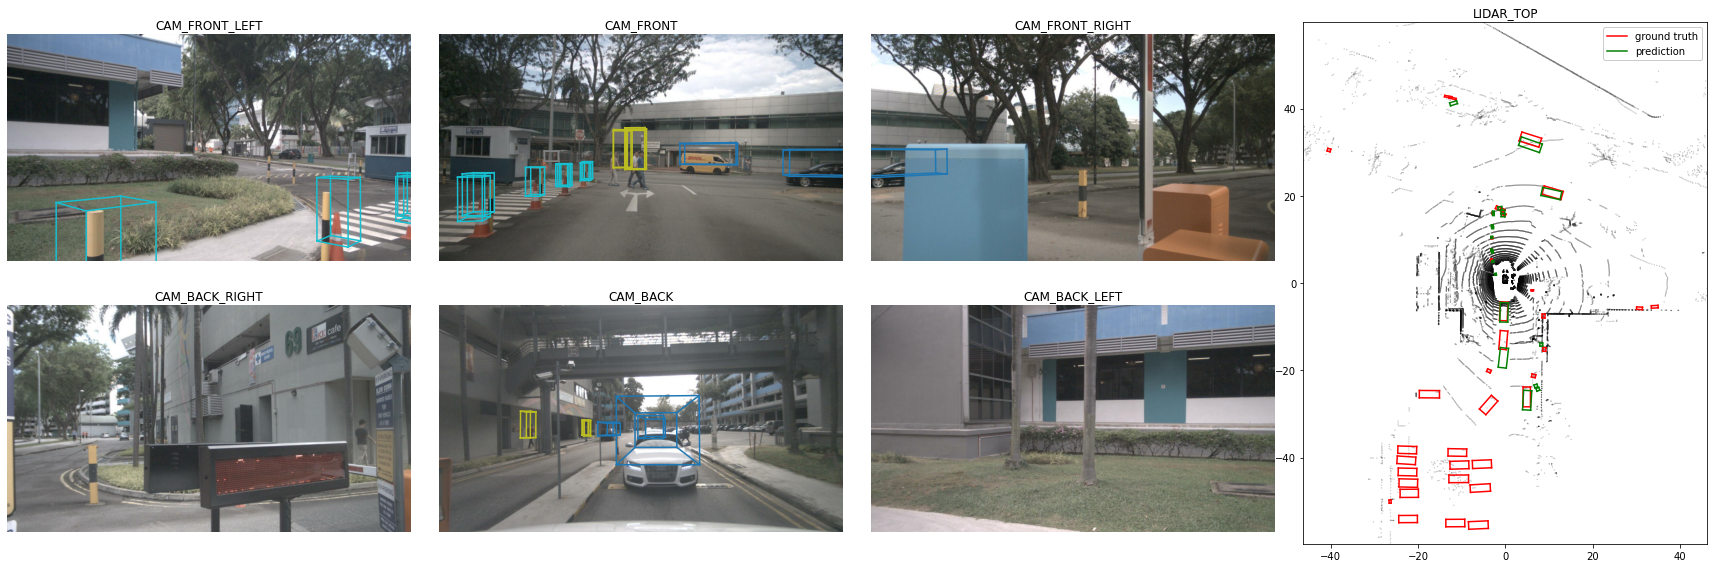

In [110]:
result_path = './outputs/bevstereo_ema_da_key2/results_nusc.json'
# target_path = './outputs/bevstereo_ema_da_key2/lightning_logs/version_0/'
data_root = '../data/nuscenes/'
results = mmcv.load(result_path)['results']
show_classes=[
    'car',
    'truck',
    'construction_vehicle',
    'bus',
    'trailer',
    'barrier',
    'motorcycle',
    'bicycle',
    'pedestrian',
    'traffic_cone',
]

# Set cameras
threshold = 0.4
show_range = 60
IMG_KEYS = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT', 'CAM_BACK', 'CAM_BACK_LEFT']

# Get data from dataset
info = infos[idx]
lidar_path = info['lidar_infos']['LIDAR_TOP']['filename']
lidar_points = np.fromfile(os.path.join(data_root, lidar_path), dtype=np.float32, count=-1).reshape(-1, 5)[..., :4]
lidar_calibrated_sensor = info['lidar_infos']['LIDAR_TOP']['calibrated_sensor']

# Get point cloud
pts = lidar_points.copy()
ego2global_rotation = np.mean([info['cam_infos'][cam]['ego_pose']['rotation'] for cam in IMG_KEYS], 0)
ego2global_translation = np.mean([info['cam_infos'][cam]['ego_pose']['translation'] for cam in IMG_KEYS], 0)
lidar_points = LidarPointCloud(lidar_points.T)
lidar_points.rotate(Quaternion(lidar_calibrated_sensor['rotation']).rotation_matrix)
lidar_points.translate(np.array(lidar_calibrated_sensor['translation']))
pts = lidar_points.points.T

# Get GT corners
gt_corners = []
for i in range(len(info['ann_infos'])):
    if map_name_from_general_to_detection[info['ann_infos'][i]['category_name']] in show_classes:
        box = get_ego_box(
            dict(
                size=info['ann_infos'][i]['size'],
                rotation=info['ann_infos'][i]['rotation'],
                translation=info['ann_infos'][i]['translation'],
            ), ego2global_rotation, ego2global_translation)
        if np.linalg.norm(box[:2]) <= show_range:
            corners = get_corners(box[None])[0]
            gt_corners.append(corners)

# Get prediction corners
pred_corners, pred_class = [], []
for box in results[info['sample_token']]:
    if box['detection_score'] >= threshold and box['detection_name'] in show_classes:
        box3d = get_ego_box(box, ego2global_rotation, ego2global_translation)
        box3d[2] += 0.5 * box3d[5]  # NOTE
        if np.linalg.norm(box3d[:2]) <= show_range:
            corners = get_corners(box3d[None])[0]
            pred_corners.append(corners)
            pred_class.append(box['detection_name'])

# Set figure size
plt.figure(figsize=(24, 8))

for i, k in enumerate(IMG_KEYS):
    # Draw camera views
    fig_idx = i + 1 if i < 3 else i + 2
    plt.subplot(2, 4, fig_idx)

    # Set camera attributes
    plt.title(k)
    plt.axis('off')
    plt.xlim(0, 1600)
    plt.ylim(900, 0)

    img = mmcv.imread(os.path.join(data_root, info['cam_infos'][k]['filename']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw images
    plt.imshow(img)

    # Draw 3D predictions
    for corners, cls in zip(pred_corners, pred_class):
        cam_corners = get_cam_corners(
            corners,
            info['cam_infos'][k]['calibrated_sensor']['translation'],
            info['cam_infos'][k]['calibrated_sensor']['rotation'],
            info['cam_infos'][k]['calibrated_sensor']['camera_intrinsic'])
        lines = get_3d_lines(cam_corners)
        for line in lines:
            plt.plot(line[0],
                     line[1],
                     c=cm.get_cmap('tab10')(show_classes.index(cls)))

# Draw BEV
plt.subplot(1, 4, 4)

# Set BEV attributes
plt.title('LIDAR_TOP')
plt.axis('equal')
plt.xlim(-40, 40)
plt.ylim(-40, 40)

# Draw point cloud
plt.scatter(-pts[:, 1], pts[:, 0], s=0.01, c=pts[:, -1], cmap='gray')

# Draw BEV GT boxes
for corners in gt_corners:
    lines = get_bev_lines(corners)
    for line in lines:
        plt.plot([-x for x in line[1]],
                 line[0],
                 c='r',
                 label='ground truth')

# Draw BEV predictions
for corners in pred_corners:
    lines = get_bev_lines(corners)
    for line in lines:
        plt.plot([-x for x in line[1]], line[0], c='g', label='prediction')

# Set legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(),
           by_label.keys(),
           loc='upper right',
           framealpha=1)

plt.tight_layout(w_pad=0, h_pad=2)
plt.show()
# plt.savefig(target_path+"output_"+str(idx)+".jpg")

plt.close()